# Growth Binary Data Evaluation

This notebook serves as data evaluation notebook (with a few interpretations). Here we combine datasets, do statistics and created figures.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from PARAMS import *
from scipy.stats import ttest_ind, ttest_rel
from statannotations.Annotator import Annotator
from itertools import combinations
%run -i PARAMS.py

## 1. Batch additive screening

We know that centrifugating the samples is important so we will look at the centrifugated data and create barplots which compare the different additives but each with all four strains. Batch additives are additives which are composed of more than one metabolite. For all tests cobalt was already added to CGXII. All samples were inoculated at starting ODs around 0.2 and had 0.2% of Tween.

### 1. Data preparation

First we have to read all data into one dataframe. Then we will transform the dataframe to be able to plot it easily with sns.

In [100]:
datasets = [
    '../data/raw/2023-01-11_CGXII_14.csv', # 14
    '../data/raw/2023-01-12_CGXII-16.csv', # 16
    '../data/raw/2023-01-17_CGXII_17.csv', # 17
    #'../data/raw/2023-01-24_CGXII_15.csv.csv', # 15
]
# read csv files
frames = [pd.read_csv(df).set_index('short').drop(['not c', '+Trace not c', '+Sacc not c']).reset_index() for df in datasets] 
# special case for strain 15 because of extra CasA measurement
frames = frames + [pd.read_csv('../data/raw/2023-01-24_CGXII_15.csv').set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+CasA not c']).reset_index()]
# add all frames to one frame
data = pd.concat(frames, axis=1)
# remove duplicate 'short' columns
data = data.loc[:,~data.columns.duplicated()].copy()
data

,short,14-0-1,14-24-1,14-0-2,14-24-2,14-0-3,14-24-3,16-0-1,16-0-2,16-0-3,...,17-0-3,17-24-1,17-24-2,17-24-3,15-0-1,15-0-2,15-0-3,15-24-1,15-24-2,15-24-3
0,+Tween c,0.229,0.724,0.226,0.741,0.227,0.748,0.216,0.222,0.224,...,0.163,0.205,0.794,0.552,0.175,0.188,0.172,0.285,0.315,0.293
1,+Tween+Trace c,0.224,0.926,0.207,0.674,0.201,0.642,0.224,0.227,0.226,...,0.179,0.231,0.660,0.674,0.170,0.191,0.174,0.285,0.321,0.299
2,+Tween+Sacc c,0.221,0.736,0.183,0.644,0.211,0.712,0.203,0.223,0.226,...,0.180,0.279,1.222,0.691,0.164,0.172,0.168,0.269,0.288,0.298
3,+Tween+CasA c,0.234,1.723,0.226,1.738,0.199,1.628,0.205,0.229,0.233,...,0.181,0.778,5.730,7.690,0.180,0.189,0.182,0.941,0.977,0.990


In [101]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in new.groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,level_0,short,OD,strain,time,sample,OD fold change
4,14-24-1,+Tween c,0.724,TS,24,1,3.161572
5,14-24-1,+Tween+CasA c,1.723,TS,24,1,7.363248
6,14-24-1,+Tween+Sacc c,0.736,TS,24,1,3.330317
7,14-24-1,+Tween+Trace c,0.926,TS,24,1,4.133929
12,14-24-2,+Tween c,0.741,TS,24,2,3.278761
13,14-24-2,+Tween+CasA c,1.738,TS,24,2,7.690265
14,14-24-2,+Tween+Sacc c,0.644,TS,24,2,3.519126
15,14-24-2,+Tween+Trace c,0.674,TS,24,2,3.256039
20,14-24-3,+Tween c,0.748,TS,24,3,3.295154
21,14-24-3,+Tween+CasA c,1.628,TS,24,3,8.180905


### 2. Plotting and statistics

Now that we prepared the DataFrame, we can use `seaborn` and `statsannotator` to make nice barcharts with significance bars.

In [4]:
def create_barplot_stats(data, x, y, hue, hue_order, pair1=None, pair2=None, fold=True):
    strains = STRAINS_LAB.values()
    
    ### barplot with errorbars ###
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=[greys[8], greys[0]], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains]
    
    annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, hue_order=hue_order, order=STRAINS_LAB.values())
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_test().annotate()
    
    ### styling ###
    #ax.legend(title=None, ncol=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=3, title=None, frameon=False)
    ax.tick_params(bottom=False) 
    if fold:
        ax.axhline(3, linestyle='dashed', color='k')
    ax.set_xlabel(None)
    
    return ax

In [103]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_+Tween c vs. 1197_+Tween+Trace c: t-test independent samples, P_val:4.267e-01 t=-8.840e-01
TS_+Tween c vs. TS_+Tween+Trace c: t-test independent samples, P_val:4.082e-01 t=-9.231e-01
1115_+Tween c vs. 1115_+Tween+Trace c: t-test independent samples, P_val:5.014e-03 t=-5.593e+00
1116_+Tween c vs. 1116_+Tween+Trace c: t-test independent samples, P_val:9.407e-01 t=7.912e-02


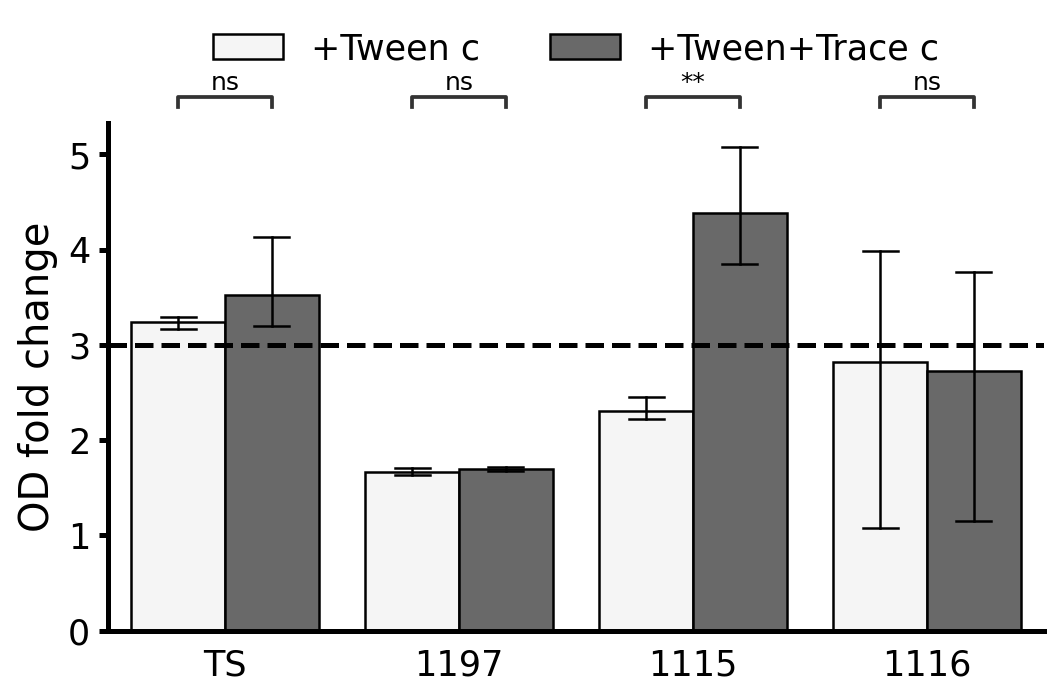

In [105]:
# input
hue_order = ['+Tween c', '+Tween+Trace c']
fig = create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
#plt.savefig('figures/plots_with_stats/trace.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_+Tween c vs. 1197_+Tween+Sacc c: t-test independent samples, P_val:5.864e-01 t=-5.908e-01
TS_+Tween c vs. TS_+Tween+Sacc c: t-test independent samples, P_val:8.319e-02 t=-2.297e+00
1115_+Tween c vs. 1115_+Tween+Sacc c: t-test independent samples, P_val:6.640e-01 t=4.682e-01
1116_+Tween c vs. 1116_+Tween+Sacc c: t-test independent samples, P_val:5.608e-01 t=-6.336e-01


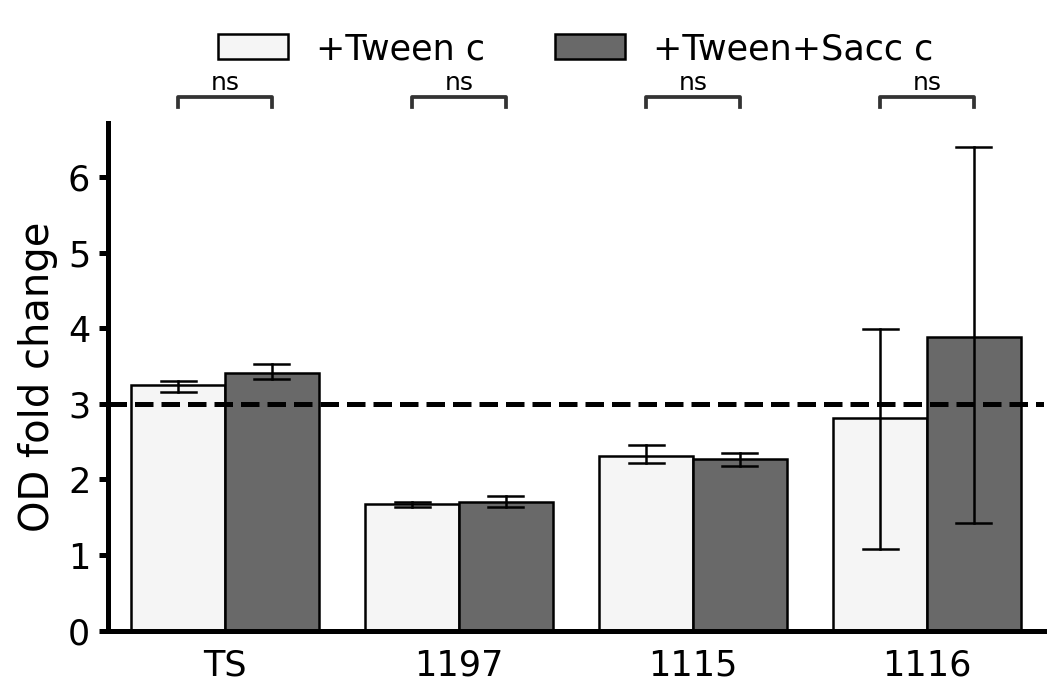

In [107]:
hue_order = ['+Tween c', '+Tween+Sacc c']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
#plt.savefig('figures/plots_with_stats/sacc.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_+Tween c vs. 1197_+Tween+CasA c: t-test independent samples, P_val:1.834e-06 t=-4.249e+01
TS_+Tween c vs. TS_+Tween+CasA c: t-test independent samples, P_val:4.869e-05 t=-1.865e+01
1115_+Tween c vs. 1115_+Tween+CasA c: t-test independent samples, P_val:9.669e-03 t=-4.649e+00
1116_+Tween c vs. 1116_+Tween+CasA c: t-test independent samples, P_val:1.244e-01 t=-1.940e+00


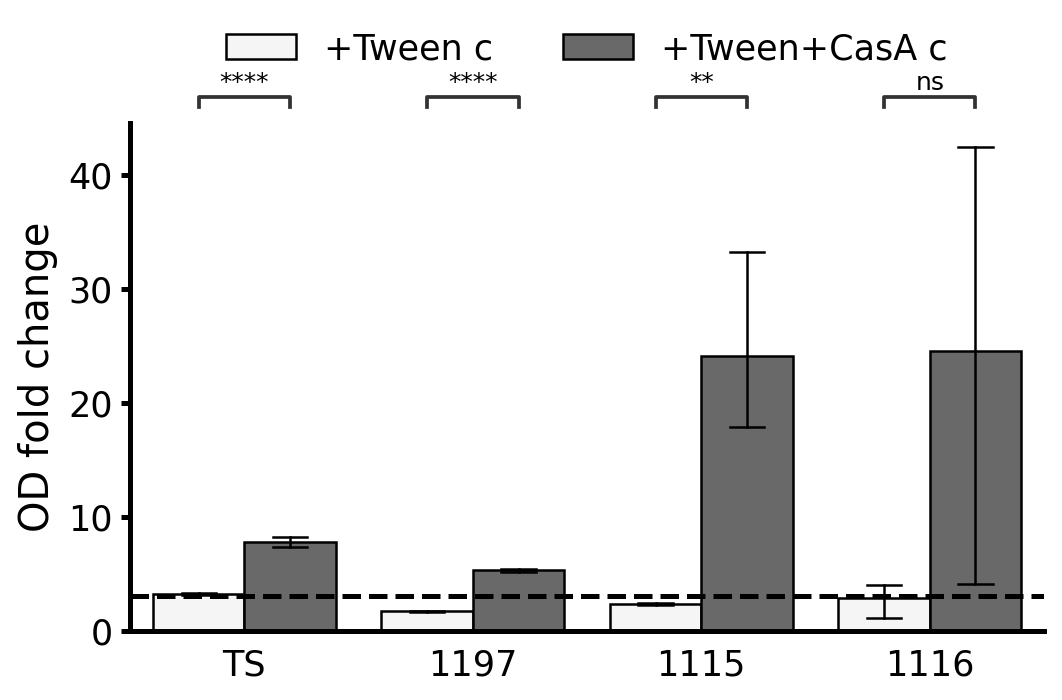

In [109]:
hue_order = ['+Tween c', '+Tween+CasA c']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
#plt.savefig('figures/plots_with_stats/casa.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1115_+Tween+Trace c vs. 1115_+Tween+CasA c: t-test independent samples, P_val:1.377e-02 t=-4.193e+00
1116_+Tween+Trace c vs. 1116_+Tween+CasA c: t-test independent samples, P_val:1.231e-01 t=-1.949e+00
TS_+Tween+Trace c vs. TS_+Tween+CasA c: t-test independent samples, P_val:3.965e-04 t=-1.094e+01
1197_+Tween+Trace c vs. 1197_+Tween+CasA c: t-test independent samples, P_val:1.728e-06 t=-4.313e+01


<AxesSubplot:ylabel='OD fold change'>

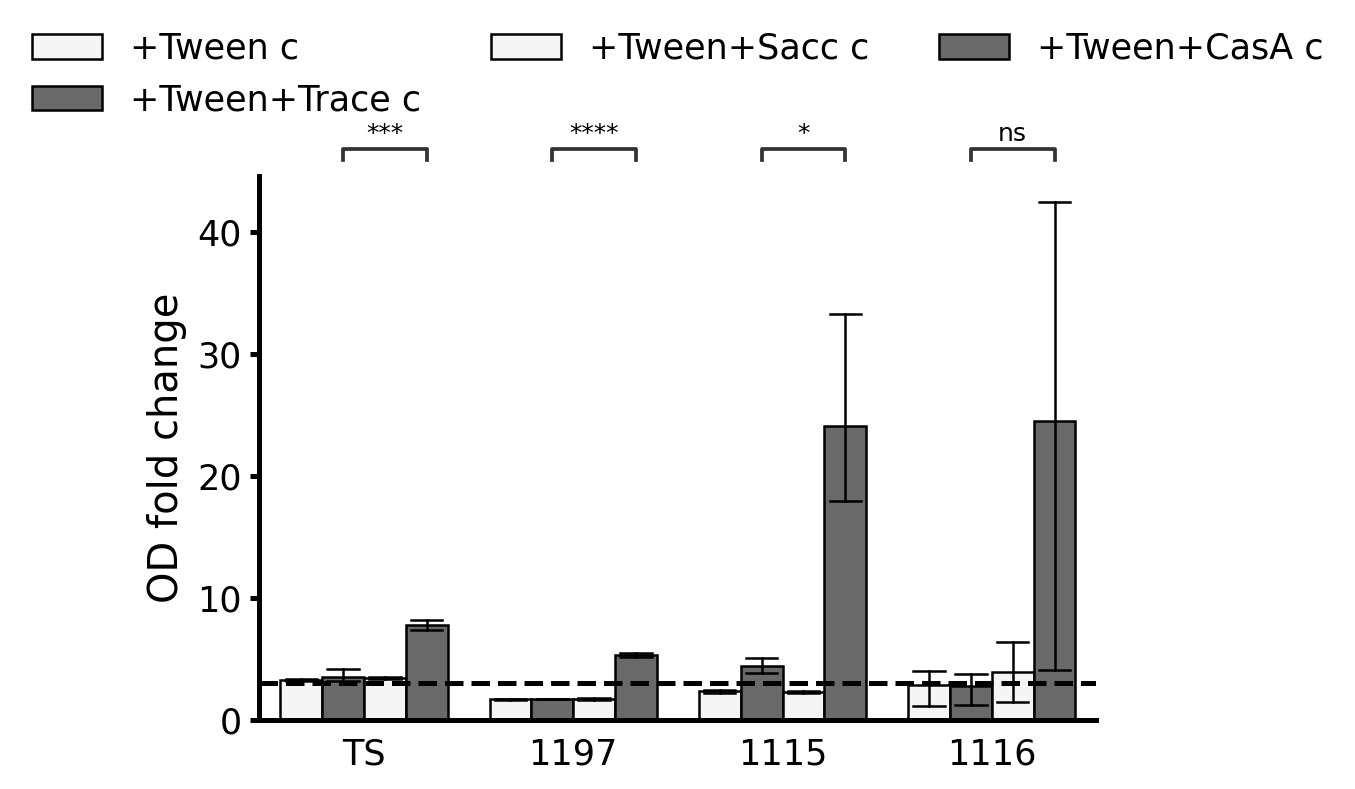

In [110]:
hue_order = ['+Tween c', '+Tween+Trace c', '+Tween+Sacc c', '+Tween+CasA c']
create_barplot_stats(data,x,y,hue,hue_order,'+Tween+Trace c', '+Tween+CasA c')

In [ ]:
plt.close('all')

## 2. Specified additive screening

Here we will again use only data from centrifugated samples. We have different groups of additives which are strain specific but a generall overview on difference between deprived CGXII and full CGXII is desired. Full CGXII is without cobalt. Most of these tests were done without t=0 measurments. Inoculation to around 0.1 OD, without Tween.

### 1. Data preparation

#### Deprived vs. native CGXII

In [ ]:
datasets = [
    '../data/raw/2022-11-08_CGXII_14-16.csv', # 14, 16
    '../data/raw/2022-11-09_CGXII_15-16.csv', # 15, 16
    '../data/raw/2022-11-10_CGXII_all.csv', # all
    #'../data/raw/2022-11-16_CGXII_all.csv', # all
    #'../data/raw/2022-11-17_CGXII_all.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/++', '+/++']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/+']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,-/-,0.005,0.000,0.000,0.027,0.083,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,-/-,0.021,0.055,0.037,NaN,NaN,NaN,0.0300,0.040,0.024,NaN,NaN,NaN
1,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
0,-/-,0.114,0.122,0.121,0.039,0.114,0.099,0.0250,0.046,0.055,0.086,0.098,0.045
1,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123


In [ ]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'-/-': 'deprived', '+/-': 'native'}, inplace=True)
depr = new
depr

,short,level_1,OD,strain,sample
0,deprived,16-1,0.0050,1115,1
1,deprived,16-2,0.0000,1115,2
2,deprived,16-3,0.0000,1115,3
3,deprived,14-1,0.0270,TS,1
4,deprived,14-2,0.0830,TS,2
5,deprived,14-3,0.0000,TS,3
6,native,16-1,1.7120,1115,1
7,native,16-2,0.0510,1115,2
8,native,16-3,0.0690,1115,3
9,native,14-1,2.3320,TS,1


#### Native vs predicted essential metabs

In [ ]:
datasets = [
    '../data/raw/2022-11-08_CGXII_14-16.csv', # 14, 16
    '../data/raw/2022-11-09_CGXII_15-16.csv', # 15, 16
    '../data/raw/2022-11-10_CGXII_all.csv', # all
    '../data/raw/2022-11-16_CGXII_all.csv', # all
    '../data/raw/2022-11-17_CGXII_all.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/-']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/++']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/++']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,+/+,0.404,0.067,0.000,0.000,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
1,+/+,NaN,NaN,NaN,NaN,NaN,NaN,1.0750,0.993,0.175,NaN,NaN,NaN
0,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123
1,+/+,NaN,NaN,NaN,0.123,0.109,0.150,NaN,NaN,NaN,0.072,0.101,0.090
0,+/-,0.128,0.174,0.135,0.153,0.160,0.135,0.0570,0.076,0.071,0.080,0.081,0.083
1,+/+,NaN,NaN,NaN,0.128,0.195,0.156,NaN,NaN,NaN,0.125,0.069,0.048
0,+/-,0.063,0.089,0.067,0.179,0.214,0.120,0.0620,0.082,0.079,0.085,0.068,0.052
1,+/+,NaN,NaN,NaN,0.128,0.177,0.146,NaN,NaN,NaN,0.085,0.068,0.052


In [ ]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'+/+': 'essential', '+/-': 'native'}, inplace=True)
ess = new
ess

,short,level_1,OD,strain,sample
0,native,16-1,1.712,1115,1
1,native,16-2,0.051,1115,2
2,native,16-3,0.069,1115,3
3,native,14-1,2.332,TS,1
4,native,14-2,0.030,TS,2
...,...,...,...,...,...
70,essential,14-2,0.177,TS,2
71,essential,14-3,0.146,TS,3
72,essential,17-1,0.085,1116,1
73,essential,17-2,0.068,1116,2


#### Native vs. predicted essential metabs AND enhancing metabs

In [ ]:
datasets = [
    '../data/raw/2022-11-08_CGXII_14-16.csv', # 14, 16
    '../data/raw/2022-11-09_CGXII_15-16.csv', # 15, 16
    '../data/raw/2022-11-10_CGXII_all.csv', # all
    '../data/raw/2022-11-16_CGXII_all.csv', # all
    '../data/raw/2022-11-17_CGXII_all.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/-']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/+']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,-/++,0.083,0.074,0.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
2,+/++,1.436,0.588,0.876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-/++,0.137,0.176,0.145,NaN,NaN,NaN,0.0540,0.060,0.046,NaN,NaN,NaN
1,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123
2,+/++,0.130,0.160,0.133,NaN,NaN,NaN,0.1570,0.122,0.107,NaN,NaN,NaN
0,+/-,0.128,0.174,0.135,0.153,0.160,0.135,0.0570,0.076,0.071,0.080,0.081,0.083
1,+/++,0.112,0.100,0.111,NaN,NaN,NaN,0.1990,0.149,0.198,NaN,NaN,NaN
0,+/-,0.063,0.089,0.067,0.179,0.214,0.120,0.0620,0.082,0.079,0.085,0.068,0.052


In [ ]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'+/++': 'enhanced', '+/-': 'native'}, inplace=True)
enh = new
enh

,short,level_1,OD,strain,sample
0,native,16-1,1.712,1115,1
1,native,16-2,0.051,1115,2
2,native,16-3,0.069,1115,3
3,native,14-1,2.332,TS,1
4,native,14-2,0.030,TS,2
...,...,...,...,...,...
73,enhanced,16-2,0.085,1115,2
74,enhanced,16-3,0.038,1115,3
75,enhanced,15-1,0.128,1197,1
76,enhanced,15-2,0.126,1197,2


### 2. Plotting and statistics

In [ ]:
# inputs that wont change
x = 'strain'
y = 'OD'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_deprived: t-test independent samples, P_val:5.810e-02 t=2.139e+00
TS_native vs. TS_deprived: t-test independent samples, P_val:3.013e-01 t=1.090e+00
1115_native vs. 1115_deprived: t-test independent samples, P_val:1.420e-02 t=2.751e+00
1116_native vs. 1116_deprived: t-test independent samples, P_val:3.399e-02 t=3.166e+00


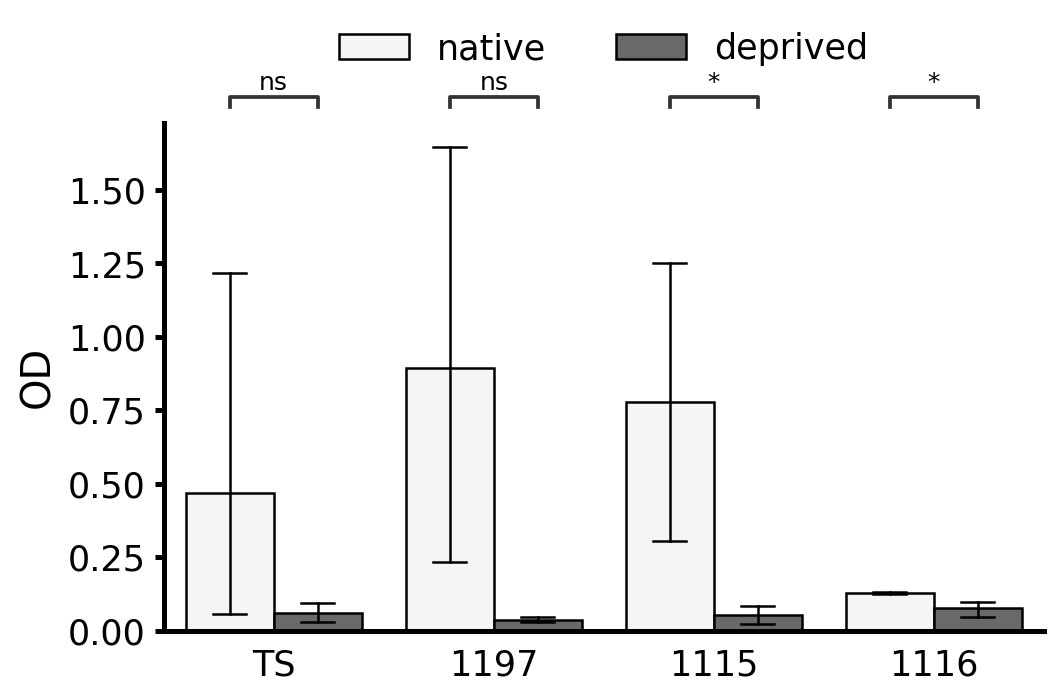

In [ ]:
data = depr
hue_order = ['native', 'deprived']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('figures/plots_with_stats/deprived.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_essential: t-test independent samples, P_val:5.924e-01 t=-5.489e-01
TS_native vs. TS_essential: t-test independent samples, P_val:2.812e-01 t=1.105e+00
1115_native vs. 1115_essential: t-test independent samples, P_val:4.003e-01 t=8.641e-01
1116_native vs. 1116_essential: t-test independent samples, P_val:2.918e-01 t=1.090e+00


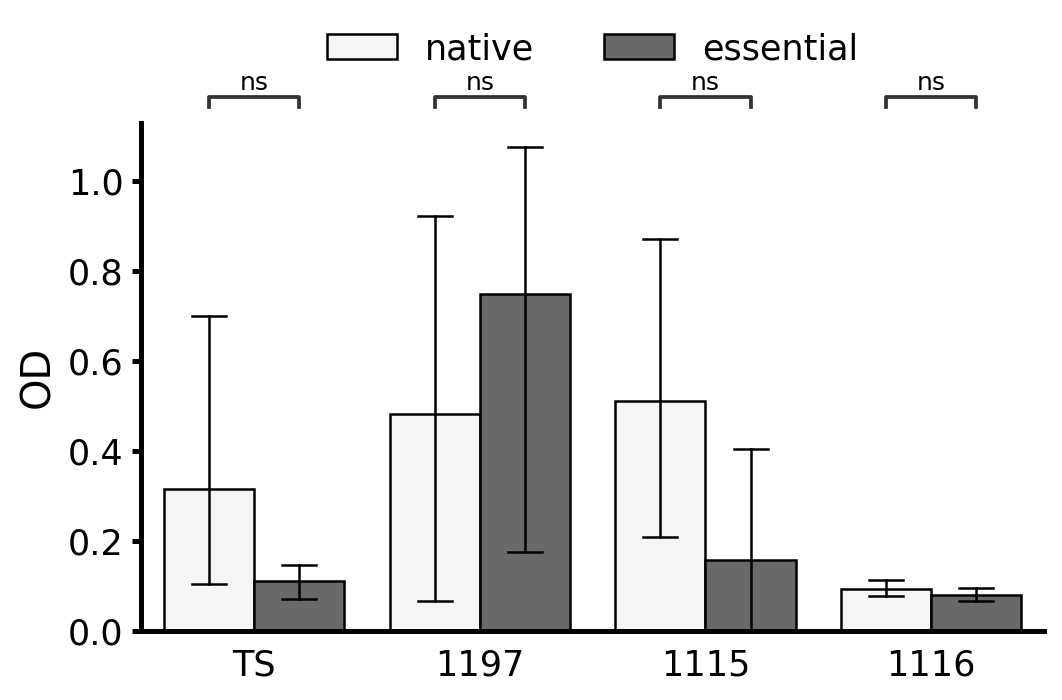

In [ ]:
data = ess
hue_order = ['native', 'essential']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('figures/plots_with_stats/essential.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_enhanced: t-test independent samples, P_val:2.227e-01 t=1.261e+00
TS_native vs. TS_enhanced: t-test independent samples, P_val:nan t=nan
1115_native vs. 1115_enhanced: t-test independent samples, P_val:4.059e-01 t=8.454e-01
1116_native vs. 1116_enhanced: t-test independent samples, P_val:nan t=nan


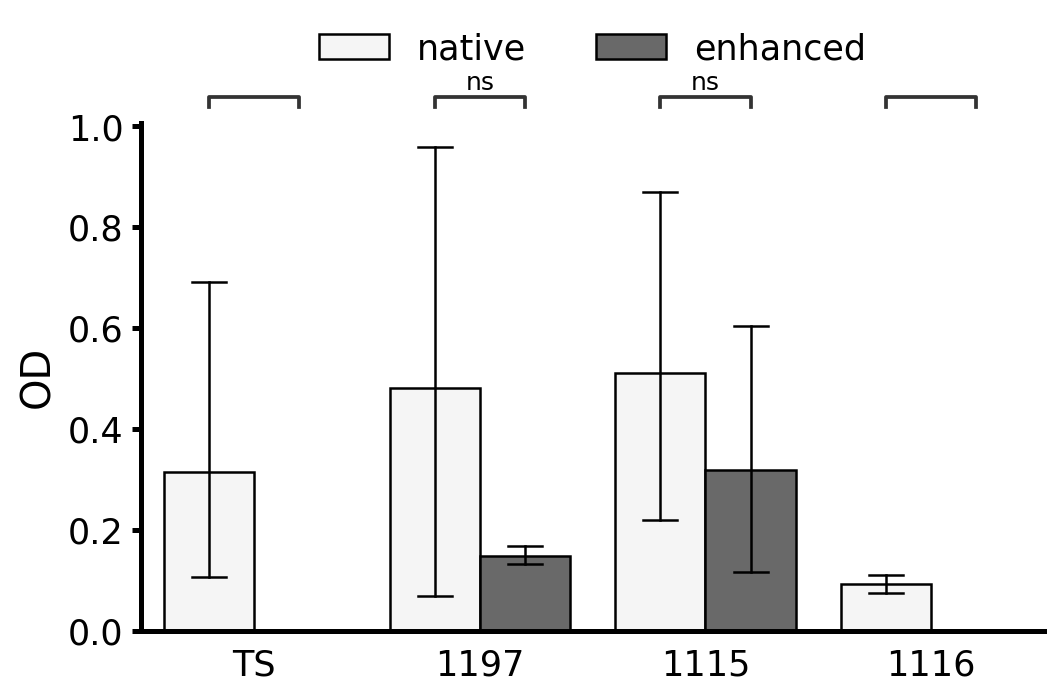

In [ ]:
data = enh
hue_order = ['native', 'enhanced']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('figures/plots_with_stats/enhanced.png')

In [ ]:
plt.close('all')

## 3. OD fold changes derived from growth curves

The same approach to 24h fold changes and statistical evaluation can be taken towards results from growth curves. We need to extract the values for t=0 and t=24 and then we can apply the same code as we did before.

### 1. Utilities for plate reader data

In [ ]:
# Utilities

from datetime import datetime
path = '../plate_reader/data/raw/'

def add_time(df):
    m = [isinstance(i, datetime) for i in df['Time']]
    df['timedelta'] = pd.to_timedelta(df['Time'].astype(str), errors='coerce')
    df.loc[m, 'timedelta'] = df.loc[m, 'Time'].apply(lambda t: pd.Timestamp(str(t)) - pd.Timestamp('1899-12-31'))
    df['Time'] = (df['timedelta'] - df['timedelta'][0])
    df['Time'] = df['Time'].dt.total_seconds() / 60
    df['Time'] += 15
    return df.drop('timedelta', axis=1)

def extract_columns(df, conditions, bio_rep=False, bio_rep_name=''):
    """transforms excel table to df where the technical triplicates are averaged

    Args:
        df (pandas-df): excel from plate reader loaded
        conditions (dict): plate_layout loaded with convert_layout()
    """

    triplicates = df.iloc[:,2:].groupby(np.arange(len(df.iloc[:,2:].columns))//3, axis=1).mean()

    blank = triplicates[triplicates.columns[3::4]]
    blank.columns = np.arange(8)

    left = triplicates[triplicates.columns[::4]]
    left.columns = np.arange(8)
    left = left - blank
    left = left.rename(columns=conditions)
    left = df.iloc[:,:1].join(left, how='outer')
    left = add_time(left)

    middle = triplicates[triplicates.columns[1::4]]
    middle.columns = np.arange(8)
    middle = middle - blank
    middle = middle.rename(columns=conditions)
    middle = df.iloc[:,:1].join(middle, how='outer')
    middle = add_time(middle)

    right = triplicates[triplicates.columns[2::4]]
    right.columns = np.arange(8)
    right = right - blank
    right = right.rename(columns=conditions)
    right = df.iloc[:,:1].join(right, how='outer')
    right = add_time(right)
    
    def double_std(array):
        return np.std(array) * 2
    
    if bio_rep:
        df_concat = pd.concat((left, middle, right))
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df_errors = by_row_index.agg([np.mean, np.std])
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right,
                   bio_rep_name: df_means}
    
    else:
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right}
        df_errors = None
    
    return  return_dict, df_errors

def convert_layout(plate_layout_file = 'plate_layout.csv'):
    """converts csv layout file to work with other functions

    Args:
        plate_layout_file (str): Path to csv with layout. Defaults to 'plate_layout.csv'.

    Returns:
        dict: date as keys and layout as value (entry of the row)
    """
    layout = pd.read_csv(plate_layout_file)
    layout_dict = {}

    for entry in layout.to_dict('records'):
        new_dict = {}
        for k, v in entry.items():
            try: 
                k = int(k)
                new_dict[k] = v
            except(ValueError):
                new_dict[k] = v
        layout_dict[new_dict['date']] = new_dict
    
    return layout_dict

def get_info(excel_file):
    date = excel_file[:6]
    nice_date = date[4:] + '.' + date[2:4] + '.20' + date[:2]
    plate_layout = convert_layout('../plate_reader/plate_layout.csv')[int(date)]
    nrows = 0 
    if plate_layout['duration'] == 24.0:
        nrows = 96 #96 for 24
    if plate_layout['duration'] == 48.0:
        nrows = 193 #193 for 48h
    bio_rep_name = ''
    if plate_layout['biological replicates']:
        bio_rep_name = str(int(plate_layout['strain']))
    return nrows, plate_layout, bio_rep_name, nice_date

def get_growth_frame(excel_file, strain): # only works with bio rep
    nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
    df = pd.read_excel(path+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
    growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)
    return growth

### 2. Data preparation

In [ ]:
#pd.options.mode.chained_assignment = None
excels = ['220610','220614', '220615', '220628']
excel_file = '220610_Cstr.xlsx' 
strains = ['15', '14', '16', '17']
strain = '15'

frames = []
i = 0
for excel in excels:
    excel_file = excel + '_Cstr.xlsx'
    strain = strains[i]
    for sample in ['-1', '-2', '-3']:
        growth = get_growth_frame(excel_file, strain)[strain+sample]
        dat = growth.loc[(growth['Time']== 15.0) | (growth['Time']== 1440.0)].abs()
        dat['sample'] = sample[1:]
        dat['strain'] = strain
        frames.append(dat)
    i = i + 1
data = pd.concat(frames, axis=0)
data

,Time,LB,M9,M9+CasA,SNM+CasA,SNM+Vit+Trace,RPMI,BHI,TSB,sample,strain
0,15.0,0.009000,0.004667,0.005333,0.009333,0.006333,0.005667,0.009667,0.010000,1,15
95,1440.0,0.228000,0.026000,0.068000,0.106333,0.046667,0.350667,0.143667,0.385000,1,15
0,15.0,0.010667,0.007667,0.009667,0.008000,0.018667,0.014333,0.007667,0.012667,2,15
95,1440.0,0.302000,0.025333,0.075667,0.095000,0.061000,0.369667,0.165667,0.554333,2,15
0,15.0,0.008000,0.007000,0.007667,0.007333,0.013000,0.005667,0.007667,0.007000,3,15
95,1440.0,0.421333,0.022000,0.048667,0.086667,0.049333,0.350333,0.206000,0.550333,3,15
0,15.0,0.008000,0.001667,0.000333,0.001000,0.003667,0.001667,0.005333,0.009000,1,14
95,1440.0,0.480667,0.002333,0.000333,0.090667,0.001000,0.281000,0.664000,0.532667,1,14
0,15.0,0.000667,0.001000,0.001667,0.000667,0.003667,0.000333,0.004333,0.004000,2,14
95,1440.0,0.582667,0.001333,0.002333,0.095000,0.017667,0.285333,0.272667,0.342333,2,14


In [ ]:
# group by time to determine fold
time = [v for k, v in data.groupby('Time')]
change = time[1].set_index(['sample', 'strain']).divide(time[0].set_index(['sample', 'strain']))
change.reset_index(inplace=True)
# melt to make columns into id variables
change = change.melt(id_vars=['sample', 'strain', 'Time']).rename({'variable':'medium', 'value':'OD fold change'}, axis=1)
# replace strain names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,sample,strain,Time,medium,OD fold change
0,1,1197,96.0,LB,25.333333
1,2,1197,96.0,LB,28.312500
2,3,1197,96.0,LB,52.666667
3,1,TS,96.0,LB,60.083333
4,2,TS,96.0,LB,874.000000
...,...,...,...,...,...
91,2,1115,96.0,TSB,78.629630
92,3,1115,96.0,TSB,260.214286
93,1,1116,96.0,TSB,45.090909
94,2,1116,96.0,TSB,32.413793


### 3. Plotting and statistics

In [ ]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'medium'

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9 vs. 1197_M9+CasA: t-test independent samples, P_val:7.600e-02 t=-2.380e+00
TS_M9 vs. TS_M9+CasA: t-test independent samples, P_val:6.541e-01 t=-4.834e-01
1115_M9 vs. 1115_M9+CasA: t-test independent samples, P_val:nan t=nan
1116_M9 vs. 1116_M9+CasA: t-test independent samples, P_val:1.438e-01 t=-1.814e+00


<AxesSubplot:ylabel='OD fold change'>

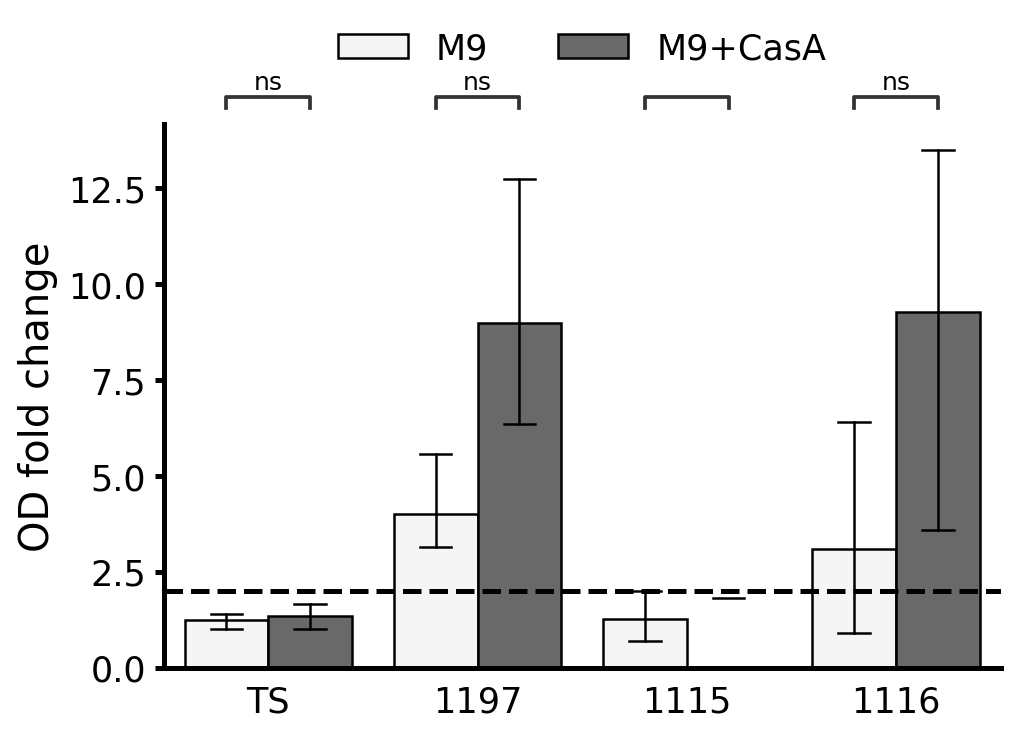

In [ ]:
hue_order = ['M9', 'M9+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_SNM+Vit+Trace vs. 1197_SNM+CasA: t-test independent samples, P_val:6.053e-03 t=-5.308e+00
TS_SNM+Vit+Trace vs. TS_SNM+CasA: t-test independent samples, P_val:5.714e-03 t=-5.394e+00
1115_SNM+Vit+Trace vs. 1115_SNM+CasA: t-test independent samples, P_val:nan t=nan
1116_SNM+Vit+Trace vs. 1116_SNM+CasA: t-test independent samples, P_val:1.241e-01 t=-1.942e+00


<AxesSubplot:ylabel='OD fold change'>

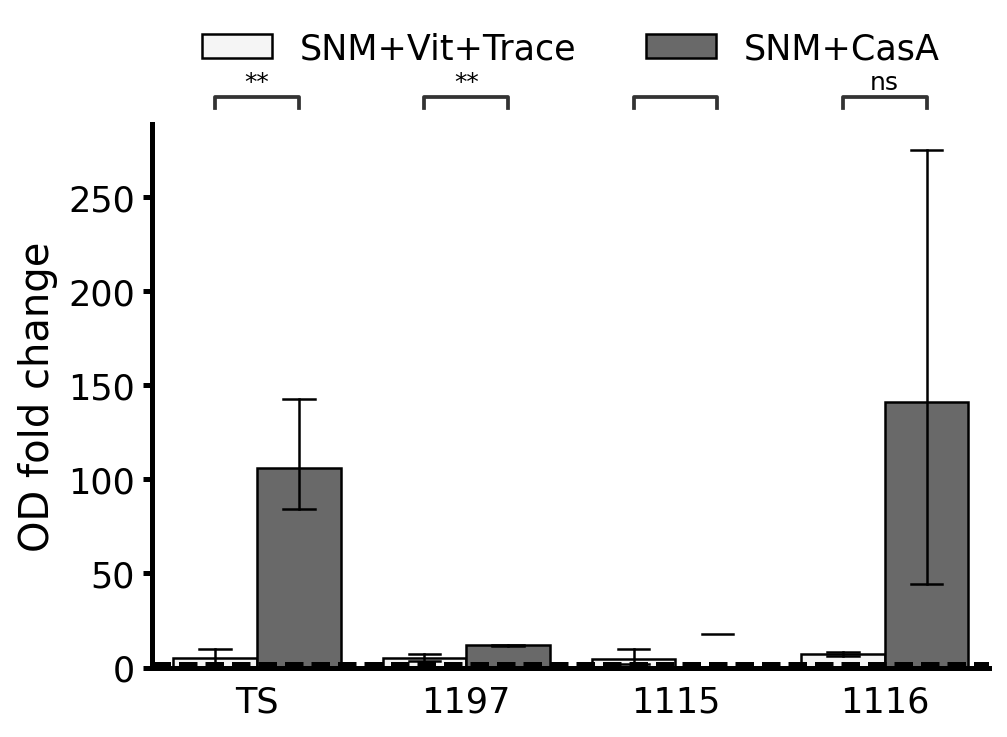

In [ ]:
hue_order = ['SNM+Vit+Trace', 'SNM+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:5452: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9+CasA vs. 1197_SNM+CasA: t-test independent samples, P_val:2.337e-01 t=-1.401e+00
TS_M9+CasA vs. TS_SNM+CasA: t-test independent samples, P_val:4.851e-03 t=-5.644e+00
1115_M9+CasA vs. 1115_SNM+CasA: t-test independent samples, P_val:nan t=nan
1116_M9+CasA vs. 1116_SNM+CasA: t-test independent samples, P_val:1.291e-01 t=-1.907e+00


<AxesSubplot:ylabel='OD fold change'>

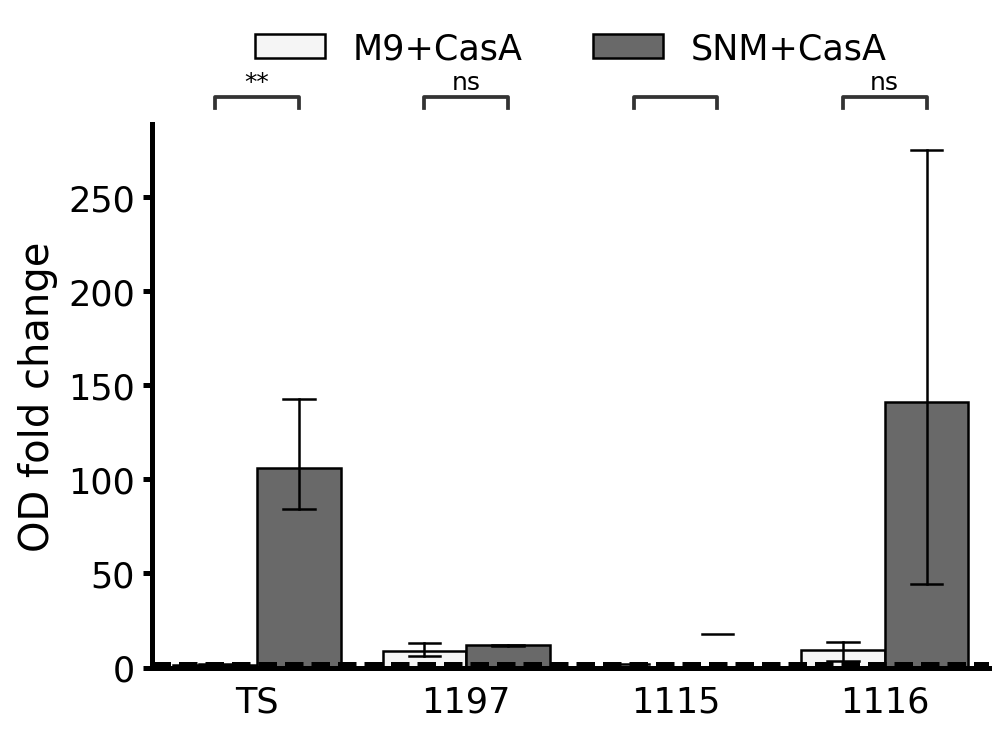

In [ ]:
hue_order = ['M9+CasA', 'SNM+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

In [ ]:
hue_order = ['M9', 'M9+CasA']

### 4. Second batch of bio rep

In [ ]:
#pd.options.mode.chained_assignment = None
excels = ['230127','230201', '230203', '230206']
strains = ['14', '16', '17', '15']

frames = []
i = 0
for excel in excels:
    excel_file = excel + '_Cstr.xlsx'
    strain = strains[i]
    for sample in ['-1', '-2', '-3']:
        growth = get_growth_frame(excel_file, strain)[strain+sample]
        dat = growth.loc[(growth['Time']== 15.0) | (growth['Time']== 1440.0)].abs()
        dat['sample'] = sample[1:]
        dat['strain'] = strain
        frames.append(dat)
    i = i + 1
data = pd.concat(frames, axis=0)
data

,Time,TSB,CGXII,CGXII+Tween,CGXII+CasA,CGXII+Tween+Trace,CGXII+Trace,CGXII+Tween+Sacch,CGXII+Sacc,sample,strain
0,15.0,0.057667,0.047333,0.052333,0.052000,0.054000,0.048667,0.055333,0.052000,1,14
95,1440.0,1.229333,0.086000,0.137667,0.208667,0.136333,0.087000,0.140000,0.089667,1,14
0,15.0,0.058000,0.042333,0.054000,0.051000,0.053667,0.047667,0.052667,0.046333,2,14
95,1440.0,1.118333,0.068000,0.140333,0.199333,0.125667,0.062333,0.120667,0.093667,2,14
0,15.0,0.048667,0.040667,0.046333,0.046000,0.048667,0.043333,0.046333,0.042667,3,14
95,1440.0,0.331667,0.060667,0.132000,0.199667,0.130000,0.076000,0.114000,0.082667,3,14
0,15.0,0.039000,0.027333,0.035000,0.051333,0.038333,0.073333,0.035000,0.073333,1,16
95,1440.0,0.416000,0.063333,0.055333,0.177000,0.051000,0.082000,0.043333,0.062333,1,16
0,15.0,0.051667,0.038000,0.046333,0.069667,0.043667,0.081333,0.045000,0.076667,2,16
95,1440.0,0.279667,0.098000,0.079333,0.207333,0.058333,0.078000,0.058000,0.065667,2,16


In [ ]:
# group by time to determine fold
time = [v for k, v in data.groupby('Time')]
change = time[1].set_index(['sample', 'strain']).divide(time[0].set_index(['sample', 'strain']))
change.reset_index(inplace=True)
# melt to make columns into id variables
change = change.melt(id_vars=['sample', 'strain', 'Time']).rename({'variable':'medium', 'value':'OD fold change'}, axis=1)
# replace strain names
change['strain'].replace(STRAINS_LAB, inplace=True)
second = change.copy()
second

,sample,strain,Time,medium,OD fold change
0,1,TS,96.0,TSB,21.317919
1,2,TS,96.0,TSB,19.281609
2,3,TS,96.0,TSB,6.815068
3,1,1115,96.0,TSB,10.666667
4,2,1115,96.0,TSB,5.412903
...,...,...,...,...,...
91,2,1116,96.0,CGXII+Sacc,0.954248
92,3,1116,96.0,CGXII+Sacc,0.325000
93,1,1197,96.0,CGXII+Sacc,1.080645
94,2,1197,96.0,CGXII+Sacc,0.753333


In [ ]:
data = second

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+Tween: t-test independent samples, P_val:3.490e-02 t=3.138e+00
TS_CGXII vs. TS_CGXII+Tween: t-test independent samples, P_val:1.032e-03 t=-8.540e+00
1115_CGXII vs. 1115_CGXII+Tween: t-test independent samples, P_val:1.904e-02 t=3.804e+00
1116_CGXII vs. 1116_CGXII+Tween: t-test independent samples, P_val:1.297e-01 t=1.903e+00


<AxesSubplot:ylabel='OD fold change'>

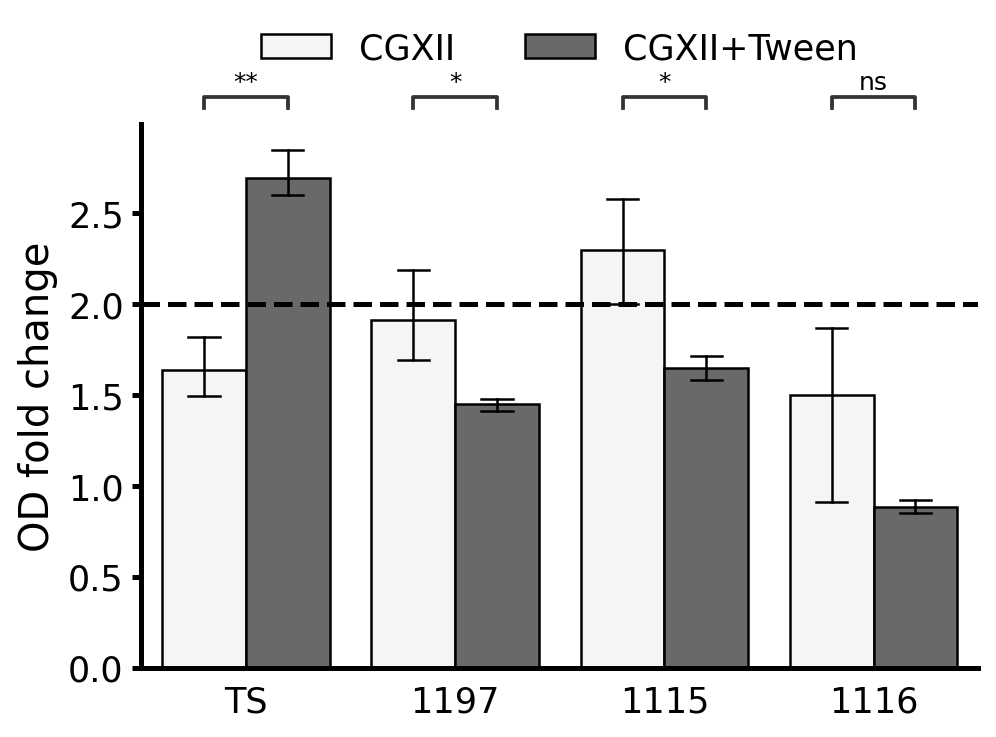

In [ ]:
hue_order = ['CGXII', 'CGXII+Tween']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+CasA: t-test independent samples, P_val:1.620e-03 t=-7.586e+00
TS_CGXII vs. TS_CGXII+CasA: t-test independent samples, P_val:1.096e-04 t=-1.519e+01
1115_CGXII vs. 1115_CGXII+CasA: t-test independent samples, P_val:8.565e-01 t=-1.928e-01
1116_CGXII vs. 1116_CGXII+CasA: t-test independent samples, P_val:4.788e-02 t=-2.819e+00


<AxesSubplot:ylabel='OD fold change'>

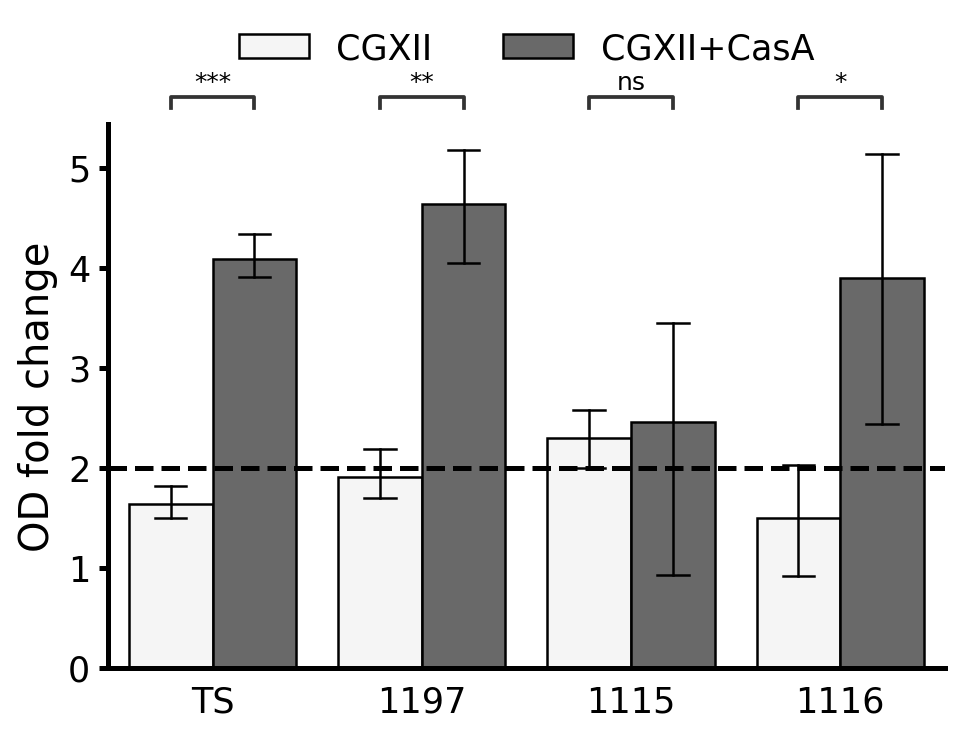

In [ ]:
hue_order = ['CGXII', 'CGXII+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+Sacc: t-test independent samples, P_val:7.312e-03 t=5.034e+00
TS_CGXII vs. TS_CGXII+Sacc: t-test independent samples, P_val:1.200e-01 t=-1.971e+00
1115_CGXII vs. 1115_CGXII+Sacc: t-test independent samples, P_val:1.237e-03 t=8.145e+00
1116_CGXII vs. 1116_CGXII+Sacc: t-test independent samples, P_val:1.309e-01 t=1.896e+00


<AxesSubplot:ylabel='OD fold change'>

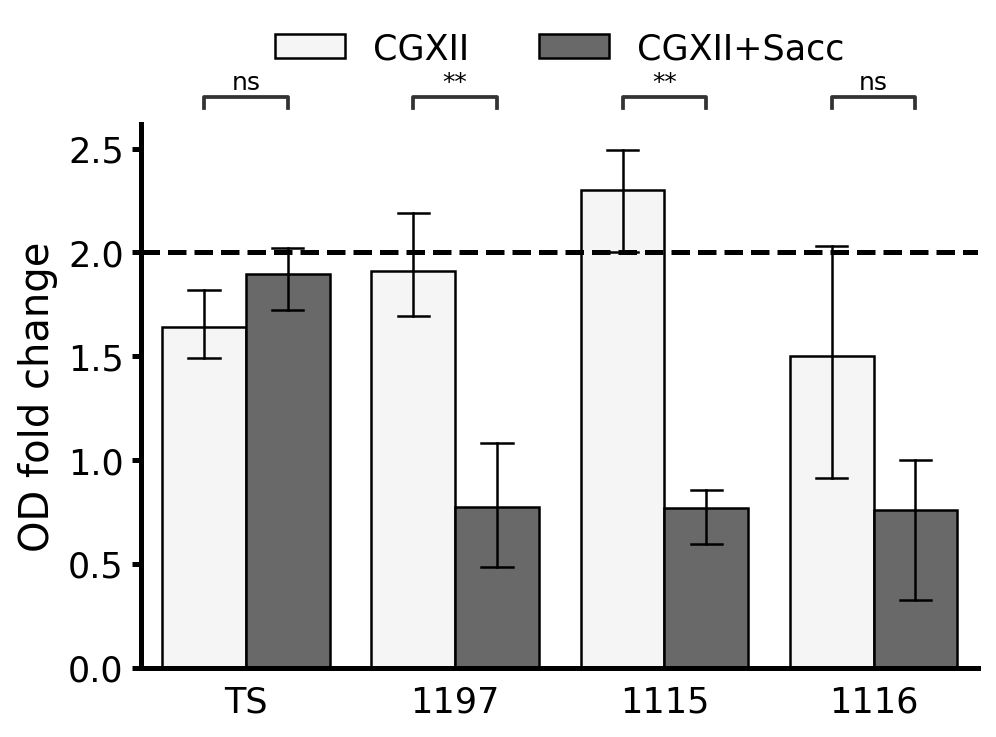

In [ ]:
hue_order = ['CGXII', 'CGXII+Sacc']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_TSB vs. 1197_CGXII+CasA: t-test independent samples, P_val:2.216e-02 t=3.630e+00
TS_TSB vs. TS_CGXII+CasA: t-test independent samples, P_val:6.108e-02 t=2.584e+00
1115_TSB vs. 1115_CGXII+CasA: t-test independent samples, P_val:2.656e-02 t=3.429e+00
1116_TSB vs. 1116_CGXII+CasA: t-test independent samples, P_val:8.166e-01 t=2.477e-01


<AxesSubplot:ylabel='OD fold change'>

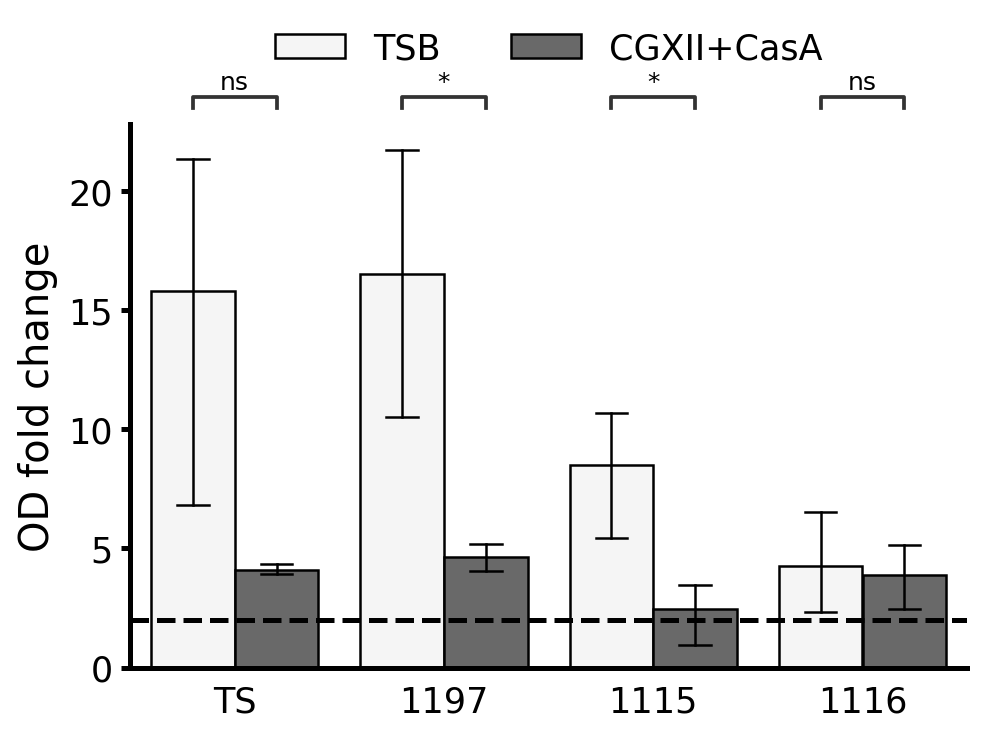

In [ ]:
hue_order = ['TSB', 'CGXII+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

## 4. Significance testing between t=0 and t=24

Usually a two-fold increase is considered growth. But what do we do with small folds, when does growth really occur? Significance testing between the two time points might reveal when growth occured.

In [ ]:
datasets = [
    '../data/raw/2023-01-11_CGXII_14.csv', # 14
    '../data/raw/2023-01-12_CGXII-16.csv', # 16
    '../data/raw/2023-01-17_CGXII_17.csv', # 17
    #'../data/raw/2023-01-24_CGXII_15.csv', # 15
]
# read csv files
frames = [pd.read_csv(df).set_index('short').drop(['not c', '+Trace not c', '+Sacc not c']).reset_index() for df in datasets] 
# special case for strain 15 because of extra CasA measurement
frames = frames + [pd.read_csv('../data/raw/2023-01-24_CGXII_15.csv').set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+CasA not c']).reset_index()]
# add all frames to one frame
data = pd.concat(frames, axis=1)
# remove duplicate 'short' columns
data = data.loc[:,~data.columns.duplicated()].copy()
data

,short,14-0-1,14-24-1,14-0-2,14-24-2,14-0-3,14-24-3,16-0-1,16-0-2,16-0-3,...,17-0-3,17-24-1,17-24-2,17-24-3,15-0-1,15-0-2,15-0-3,15-24-1,15-24-2,15-24-3
0,+Tween c,0.229,0.724,0.226,0.741,0.227,0.748,0.216,0.222,0.224,...,0.163,0.205,0.794,0.552,0.175,0.188,0.172,0.285,0.315,0.293
1,+Tween+Trace c,0.224,0.926,0.207,0.674,0.201,0.642,0.224,0.227,0.226,...,0.179,0.231,0.660,0.674,0.170,0.191,0.174,0.285,0.321,0.299
2,+Tween+Sacc c,0.221,0.736,0.183,0.644,0.211,0.712,0.203,0.223,0.226,...,0.180,0.279,1.222,0.691,0.164,0.172,0.168,0.269,0.288,0.298
3,+Tween+CasA c,0.234,1.723,0.226,1.738,0.199,1.628,0.205,0.229,0.233,...,0.181,0.778,5.730,7.690,0.180,0.189,0.182,0.941,0.977,0.990


In [ ]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
new['strain'].replace(STRAINS_LAB, inplace=True)
new

,level_0,short,OD,strain,time,sample
0,14-0-1,+Tween c,0.229,TS,0,1
1,14-0-1,+Tween+CasA c,0.234,TS,0,1
2,14-0-1,+Tween+Sacc c,0.221,TS,0,1
3,14-0-1,+Tween+Trace c,0.224,TS,0,1
4,14-24-1,+Tween c,0.724,TS,24,1
...,...,...,...,...,...,...
91,15-24-2,+Tween+Trace c,0.321,1197,24,2
92,15-24-3,+Tween c,0.293,1197,24,3
93,15-24-3,+Tween+CasA c,0.990,1197,24,3
94,15-24-3,+Tween+Sacc c,0.298,1197,24,3


In [5]:
def create_barplot_stats_grid(data, x, y, hue, col, hue_order, pair1=None, pair2=None):
    strains = STRAINS_LAB.values()
    plot_params = {
        'x': x,
        'y': y,
        'hue': hue,
        'palette':[greys[8], greys[0]], 
        'edgecolor':'k',
        'capsize': .15, 
        'errwidth': 1, 
        'errcolor': 'k',
        'order': STRAINS_LAB.values(),
        'estimator':np.mean
    }
    
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains]
    
    config = {
        'test': 't-test_ind',
        'text_format': 'star',
        #'loc': 'outside'
    }
    plot = 'barplot'
    annot = Annotator(None, pairs)
    g = sns.FacetGrid(
        data=data,
        col=col,
        col_wrap=3
    )
    g = g.map_dataframe(
        annot.plot_and_annotate_facets,
        data=data,
        plot=plot, 
        plot_params=plot_params,
        configuration=config, 
        annotation_func='apply_test', 
    )
    g = g.set_titles(row_template = '{row_name}', col_template = '{col_name}', fontsize=10)
    g = g.set_xlabels(None)
    g = g.add_legend()
    sns.move_legend(g, "upper left", bbox_to_anchor=(.70, .40), title='time point [h]')
    
    return g

In [ ]:
# inputs that wont change
data = new[~new.short.str.contains("nac", na=False)]
data = data[~data.short.str.contains("CasA", na=False)]
x = 'strain'
y = 'OD'
hue = 'time'
col = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:4.315e-02 t=-2.922e+00
TS_0 vs. TS_24: t-test independent samples, P_val:5.636e-04 t=-9.993e+00
1115_0 vs. 1115_24: t-test independent samples, P_val:6.385e-01 t=-5.075e-01
1116_0 vs. 1116_24: t-test independent samples, P_val:7.226e-01 t=-3.810e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:3.082e-04 t=-1.167e+01
TS_0 vs. TS_24: t-test independent samples, P_val:2.348e-07 t=-7.107e+01
1115_0 vs. 1115_24: t-test independent samples, P_val:1.792e-04 t=-1.340e+01
1116_0 vs. 1116_24: t-test independent samples, P_val:2.824e-02 t=-3.363e+00
p-value annotation legend:
   

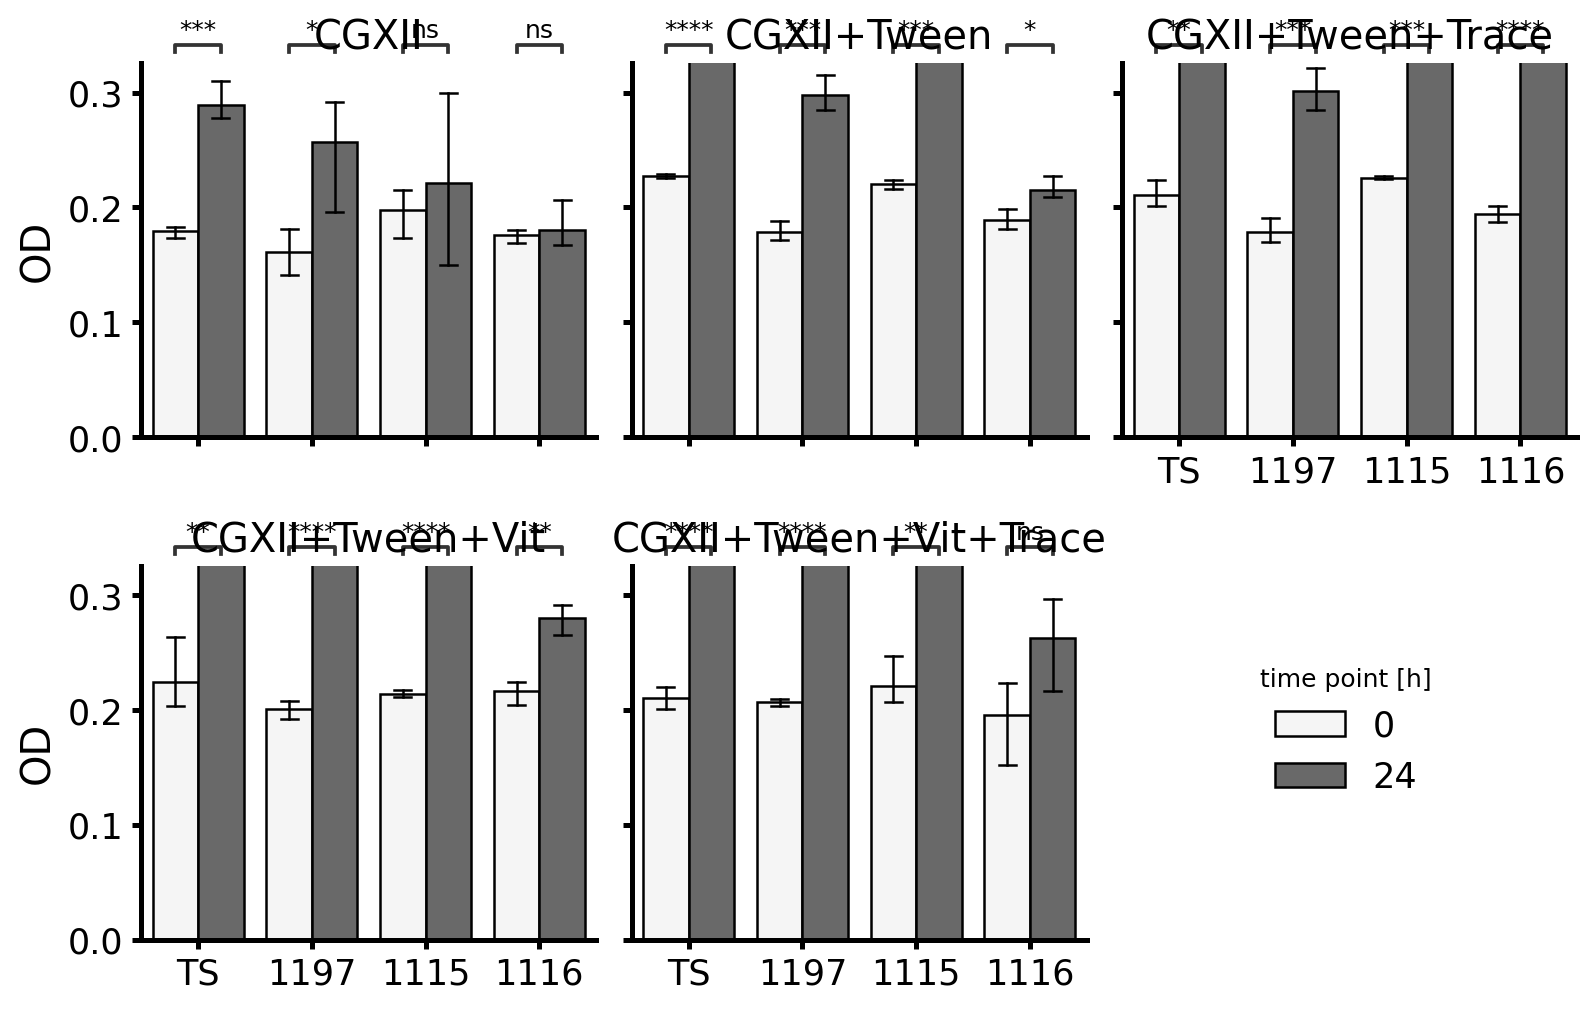

In [ ]:
hue_order = ['0', '24']
fig = create_barplot_stats_grid(data,x,y,hue,col,hue_order)

## 5. Screening on M9 medium

In [4]:
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in pd.read_csv('../data/agg/M9_OD.csv').groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,lab_mapping,short,OD,strain,time,sample,OD fold change
15,14-24-1,M9,0.226,TS,24,1,1.228261
16,14-24-1,M9+Tween,0.388,TS,24,1,1.694323
17,14-24-1,M9+Tween+CasA,2.630,TS,24,1,11.191489
18,14-24-1,M9+adds,0.356,TS,24,1,1.893617
19,14-24-1,M9+adds+CasA,1.404,TS,24,1,6.622642
...,...,...,...,...,...,...,...
127,17-24-3,M9+Tween+CasA,2.360,1116,24,3,10.776256
128,17-24-3,M9+Tween+nac,2.570,1116,24,3,13.526316
129,17-24-3,M9+Tween+nac+CasA,2.220,1116,24,3,11.502591
130,17-24-3,M9+adds,0.307,1116,24,3,1.641711


In [59]:
change.groupby(['strain', 'short']).mean()

OD  time  sample  OD fold change
strain short                                                    
1115   M9                 0.284333    24       2        1.370290
       M9+Tween           0.421667    24       2        1.707824
       M9+Tween+CasA      2.023333    24       2        7.519966
       M9+adds            0.604333    24       2        3.232235
       M9+adds+CasA       2.113667    24       2       10.497439
1116   M9                 0.555000    24       2        2.491845
       M9+Tween           0.554333    24       2        2.384864
       M9+Tween+CasA      1.740000    24       2        7.894840
       M9+Tween+nac       2.456667    24       2       12.600329
       M9+Tween+nac+CasA  2.330000    24       2       12.163484
       M9+adds            0.329667    24       2        1.690936
       M9+adds+CasA       1.169000    24       2        5.119512
1197   M9                 1.031000    24       2        4.780823
       M9+Tween           0.513000    24       2        2.317104
       M9+Tween+CasA      1.776667    24       2        7.292393
       M9+adds            0.719000    24       2        4.056277
       M9+adds+CasA       2.586667    24       2       13.190394
TS     M9                 0.286333    24       2        1.567937
       M9+Tween           0.397667    24       2        1.835223
       M9+Tween+CasA      2.030000    24       2        9.002938
       M9+adds            0.365667    24       2        1.966341
       M9+adds+CasA       1.481333    24       2        6.918726

In [5]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9 vs. 1197_M9+Tween: t-test independent samples, P_val:2.660e-04 t=1.212e+01
TS_M9 vs. TS_M9+Tween: t-test independent samples, P_val:2.872e-01 t=-1.227e+00
1115_M9 vs. 1115_M9+Tween: t-test independent samples, P_val:3.007e-03 t=-6.431e+00
1116_M9 vs. 1116_M9+Tween: t-test independent samples, P_val:8.661e-01 t=1.797e-01


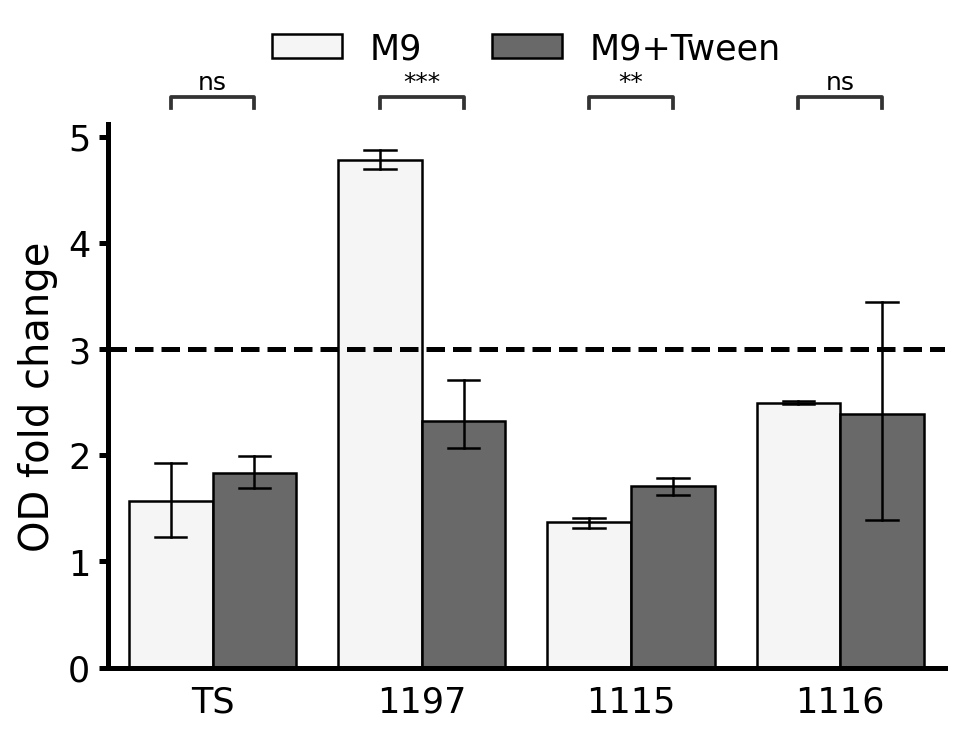

In [7]:
# input
hue_order = ['M9', 'M9+Tween']
fig = create_barplot_stats(data,x,y,hue,hue_order)
plt.savefig('../figures/plots_with_stats/M9_sig_plainToTween.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9 vs. 1197_M9+adds: t-test independent samples, P_val:2.021e-03 t=7.153e+00
TS_M9 vs. TS_M9+adds: t-test independent samples, P_val:1.380e-01 t=-1.850e+00
1115_M9 vs. 1115_M9+adds: t-test independent samples, P_val:1.032e-03 t=-8.540e+00
1116_M9 vs. 1116_M9+adds: t-test independent samples, P_val:5.655e-04 t=9.984e+00


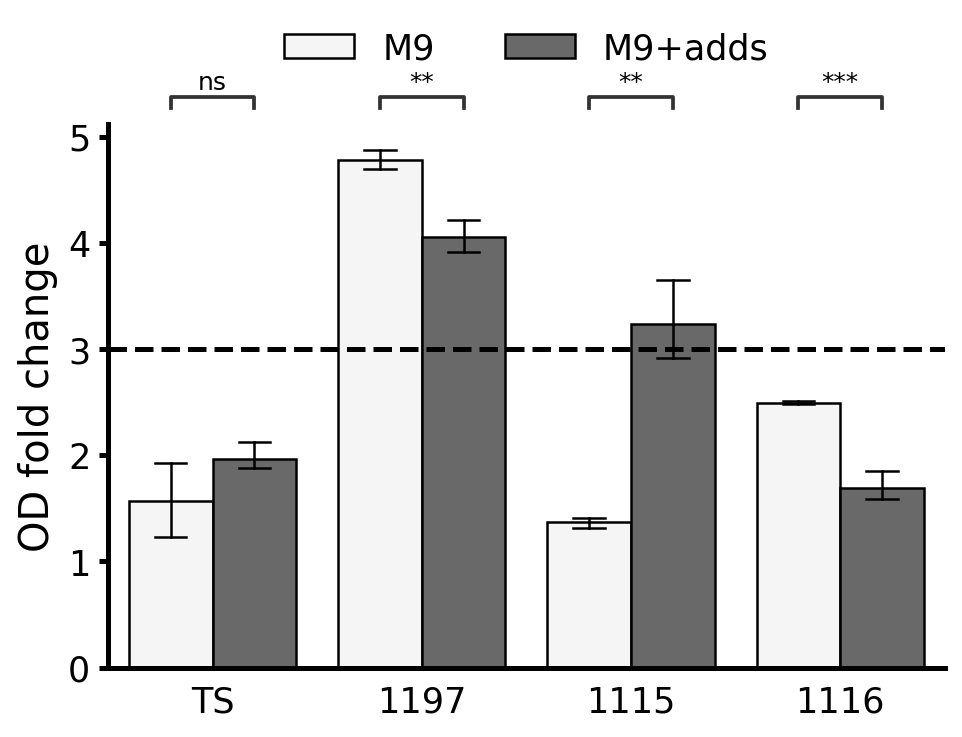

In [8]:
hue_order = ['M9', 'M9+adds']
fig = create_barplot_stats(data,x,y,hue,hue_order)

In [102]:
def create_barplot_stats_triple(data, x, y, hue, hue_order, pair1=None, pair2=None, fold=True):
    strains = STRAINS_LAB.values()
    
    ### barplot with errorbars ###
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=[greys[8], greys[4], greys[0]], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        pair3 = hue_order[2]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains] + [((strain, pair1), (strain, pair3))
                for strain in strains]
    
    annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, hue_order=hue_order, order=STRAINS_LAB.values())
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_test().annotate()
    
    ### styling ###
    #ax.legend(title=None, ncol=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.20), ncol=3, title=None, frameon=False)
    ax.tick_params(bottom=False) 
    if fold:
        ax.axhline(3, linestyle='dashed', color='k')
    ax.set_xlabel(None)
    
    return ax

In [26]:
def create_barplot_stats_four(data, x, y, hue, hue_order, pair1=None, pair2=None, fold=True):
    strains = STRAINS_LAB.values()
    
    ### barplot with errorbars ###
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=['white', 'lightgrey', 'darkgrey', 'dimgrey'], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        pair3 = hue_order[2]
        pair4 = hue_order[3]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains] + [((strain, pair1), (strain, pair3))
                for strain in strains] + [((strain, pair1), (strain, pair4))
                for strain in strains]
    
    annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, hue_order=hue_order, order=STRAINS_LAB.values())
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_test().annotate()
    
    ### styling ###
    #ax.legend(title=None, ncol=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.0), ncol=2, title=None, frameon=False)
    #sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5), title=None, frameon=False)
    ax.tick_params(bottom=False) 
    ax.set_xlabel(None)
    ax.set_ylim(0,16.5)
    ax.set_yticks(np.arange(0, 16.5, step=3))
    
    return ax

In [36]:
hue_order = ['M9', 'M9+adds', 'M9+Tween+CasA']
fig = create_barplot_stats_triple(data,x,y,hue,hue_order)
plt.savefig('../figures/plots_with_stats/M9_sig_triple.png', bbox_inches='tight', dpi=300)

NameError: name 'create_barplot_stats_triple' is not defined

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1116_M9 vs. 1116_M9+Tw: t-test independent samples, P_val:8.661e-01 t=1.797e-01
1115_M9 vs. 1115_M9+Tw: t-test independent samples, P_val:3.007e-03 t=-6.431e+00
TS_M9 vs. TS_M9+Tw: t-test independent samples, P_val:2.872e-01 t=-1.227e+00
1197_M9 vs. 1197_M9+Tw: t-test independent samples, P_val:2.660e-04 t=1.212e+01
1116_M9 vs. 1116_M9+Tw+adds: t-test independent samples, P_val:5.655e-04 t=9.984e+00
TS_M9 vs. TS_M9+Tw+adds: t-test independent samples, P_val:1.380e-01 t=-1.850e+00
1197_M9 vs. 1197_M9+Tw+adds: t-test independent samples, P_val:2.021e-03 t=7.153e+00
1115_M9 vs. 1115_M9+Tw+adds: t-test independent samples, P_val:1.032e-03 t=-8.540e+00
1116_M9 vs. 1116_M9+Tw+adds+CasA: t-test independent samples, P_val:1.911e-03 t=-7.261e+00
1115_M9 vs. 1115_M9+Tw+adds+CasA: t-test independent samples, P_val:5.51

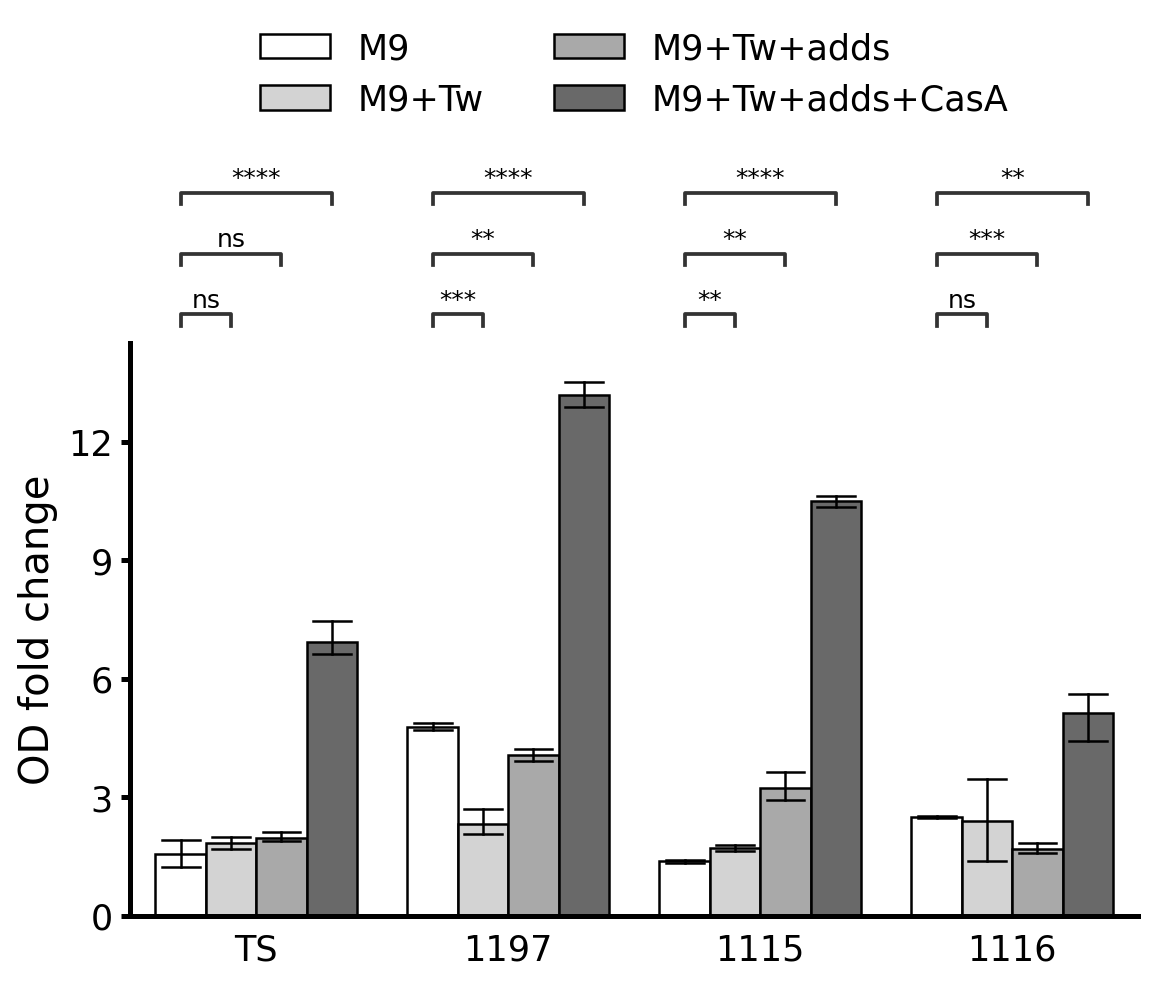

In [8]:
data.replace({'M9+Tween': 'M9+Tw', 'M9+adds': 'M9+Tw+adds', 'M9+adds+CasA': 'M9+Tw+adds+CasA'}, inplace=True)
hue_order = ['M9', 'M9+Tw', 'M9+Tw+adds', 'M9+Tw+adds+CasA']
fig = create_barplot_stats_four_cgx(data,x,y,hue,hue_order)
plt.savefig('../figures/plots_with_stats/M9_sig_four.png', bbox_inches='tight', dpi=300)

In [10]:
plt.close('all')

## 6. Batch screening on CGXII, complete

In [9]:
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in pd.read_csv('../data/agg/CGXII_OD.csv').groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
ts = change[change['strain'] == 'TS']
change = change.append(ts[ts['short'] == 'CGXII+Tween'].replace({'CGXII+Tween':'CGXII+adds'}))
ts = change[change['strain'] == 'TS']
change = change.append(ts[ts['short'] == 'CGXII+Tween+CasA'].replace({'CGXII+Tween+CasA':'CGXII+adds+CasA'}))
change[change['short'] == 'CGXII+adds+CasA']

,lab_mapping,short,OD,strain,time,sample,OD fold change
77,16-24-1,CGXII+adds+CasA,2.374,1115,24,1,11.358852
86,16-24-2,CGXII+adds+CasA,2.366,1115,24,2,11.541463
95,16-24-3,CGXII+adds+CasA,2.563,1115,24,3,11.920930
131,15-24-1,CGXII+adds+CasA,2.646,1197,24,1,12.907317
140,15-24-2,CGXII+adds+CasA,2.677,1197,24,2,12.747619
149,15-24-3,CGXII+adds+CasA,2.562,1197,24,3,12.874372
204,17-24-1,CGXII+adds+CasA,1.042,1116,24,1,5.262626
218,17-24-2,CGXII+adds+CasA,1.215,1116,24,2,5.985222
232,17-24-3,CGXII+adds+CasA,1.101,1116,24,3,5.423645
10,14-24-1,CGXII+adds+CasA,1.723,TS,24,1,7.363248


In [61]:
change.groupby(['strain', 'short']).mean()

OD  time  sample  OD fold change
strain short                                                            
1115   CGXII                      0.221000    24       2        1.104687
       CGXII+CasA                 3.760000    24       2       17.259118
       CGXII+Tween                0.509000    24       2        2.305356
       CGXII+Tween+CasA           5.276667    24       2       24.081728
       CGXII+Tween+Trace          0.989333    24       2        4.382521
       CGXII+Tween+Vit            0.401667    24       2        1.877912
       CGXII+Tween+Vit+Trace      0.399333    24       2        1.801816
       CGXII+adds                 0.581333    24       2        2.879622
       CGXII+adds+CasA            2.434333    24       2       11.607082
1116   CGXII                      0.180667    24       2        1.028119
       CGXII+CasA                 0.673333    24       2        3.509571
       CGXII+Tween                0.215333    24       2        1.141477
       CGXII+Tween+CasA           0.505667    24       2        2.109147
       CGXII+Tween+Trace          0.791333    24       2        4.064192
       CGXII+Tween+Vit            0.279667    24       2        1.293161
       CGXII+Tween+Vit+Trace      0.262667    24       2        1.350098
       CGXII+Tween+Vit+Trace+nac  0.259333    24       2        1.277811
       CGXII+Tween+Vit+nac        0.262000    24       2        1.236962
       CGXII+Tween+nac            0.329667    24       2        1.757097
       CGXII+Tween+nac+CasA       1.148333    24       2        6.013464
       CGXII+adds                 0.256000    24       2        1.306836
       CGXII+adds+CasA            1.119333    24       2        5.557164
       CGXII+nac                  0.164000    24       2        1.019783
1197   CGXII                      0.257333    24       2        1.585472
       CGXII+CasA                 1.106667    24       2        5.655436
       CGXII+Tween                0.297667    24       2        1.669197
       CGXII+Tween+CasA           0.969333    24       2        5.278883
       CGXII+Tween+Trace          0.301667    24       2        1.691830
       CGXII+Tween+Vit            0.495000    24       2        2.466851
       CGXII+Tween+Vit+Trace      0.472000    24       2        2.285010
       CGXII+adds                 0.616000    24       2        3.073425
       CGXII+adds+CasA            2.628333    24       2       12.843103
TS     CGXII                      0.289000    24       2        1.611608
       CGXII+CasA                 1.246667    24       2        6.237147
       CGXII+Tween                0.737667    24       2        3.245162
       CGXII+Tween+CasA           1.696333    24       2        7.744806
       CGXII+Tween+Trace          0.747333    24       2        3.527999
       CGXII+Tween+Vit            0.777000    24       2        3.458515
       CGXII+Tween+Vit+Trace      0.635000    24       2        3.026454
       CGXII+adds                 0.737667    24       2        3.245162
       CGXII+adds+CasA            1.696333    24       2        7.744806

In [11]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII+Tween+CasA vs. 1197_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
TS_CGXII+Tween+CasA vs. TS_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
1115_CGXII+Tween+CasA vs. 1115_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
1116_CGXII+Tween+CasA vs. 1116_CGXII+Tween+nac+CasA: t-test independent samples, P_val:1.464e-02 t=-4.118e+00


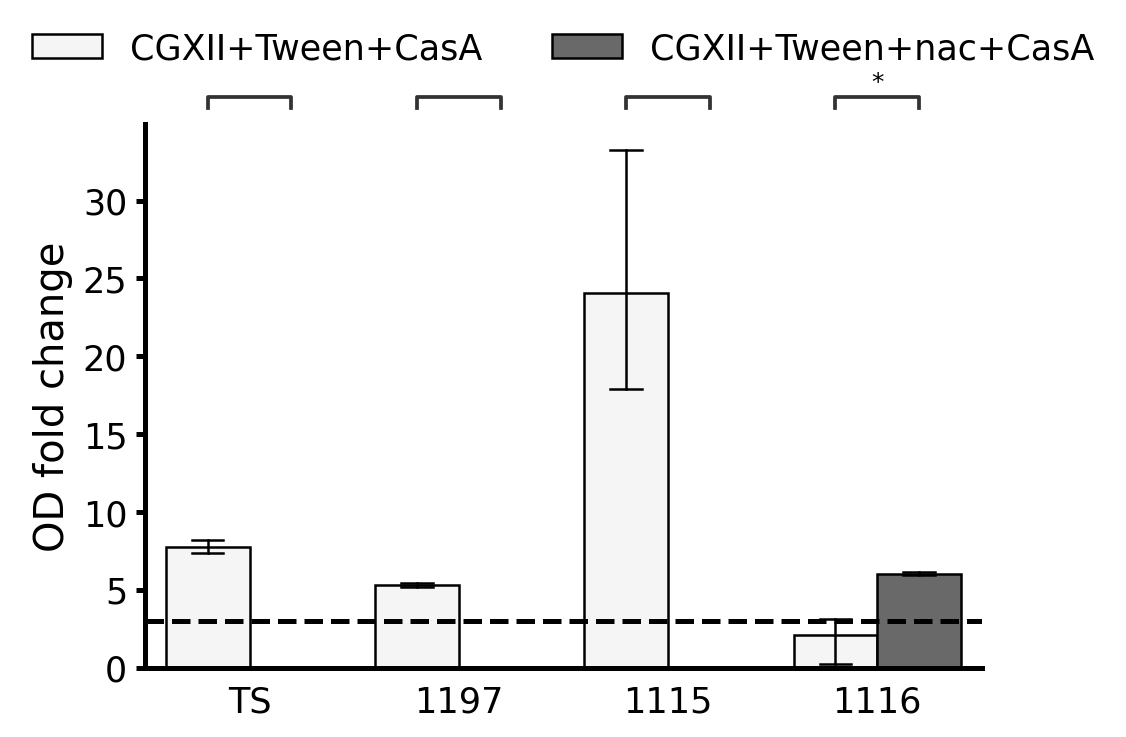

In [37]:
hue_order = ['CGXII+Tween+CasA', 'CGXII+Tween+nac+CasA']
fig = create_barplot_stats(data,x,y,hue,hue_order)
#plt.savefig('../figures/plots_with_stats/CGXII_sig_plainToTween.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+adds: t-test independent samples, P_val:7.068e-04 t=-9.424e+00
TS_CGXII vs. TS_CGXII+adds: t-test independent samples, P_val:1.640e-05 t=-2.453e+01
1115_CGXII vs. 1115_CGXII+adds: t-test independent samples, P_val:1.662e-03 t=-7.534e+00
1116_CGXII vs. 1116_CGXII+adds: t-test independent samples, P_val:2.475e-02 t=-3.506e+00


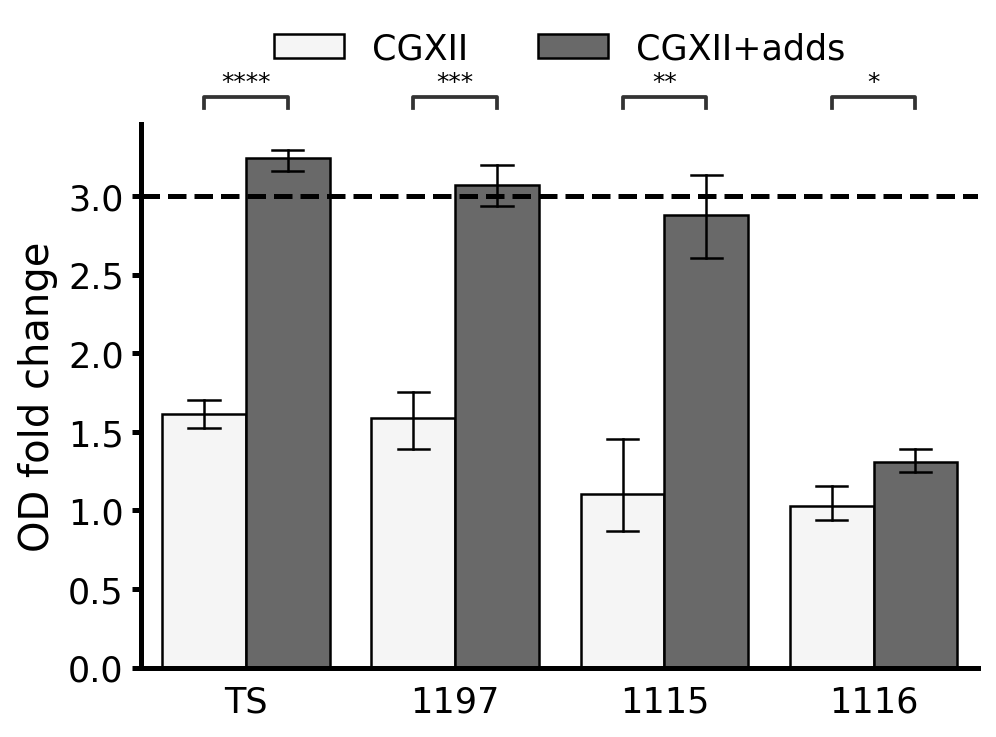

In [38]:
hue_order = ['CGXII', 'CGXII+adds']
fig = create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1115_CGXII vs. 1115_CGXII+adds: t-test independent samples, P_val:1.662e-03 t=-7.534e+00
1116_CGXII vs. 1116_CGXII+adds: t-test independent samples, P_val:2.475e-02 t=-3.506e+00
TS_CGXII vs. TS_CGXII+adds: t-test independent samples, P_val:1.640e-05 t=-2.453e+01
1197_CGXII vs. 1197_CGXII+adds: t-test independent samples, P_val:7.068e-04 t=-9.424e+00
1115_CGXII vs. 1115_CGXII+CasA: t-test independent samples, P_val:1.659e-05 t=-2.446e+01
1116_CGXII vs. 1116_CGXII+CasA: t-test independent samples, P_val:2.233e-03 t=-6.965e+00
1197_CGXII vs. 1197_CGXII+CasA: t-test independent samples, P_val:7.693e-06 t=-2.966e+01
TS_CGXII vs. TS_CGXII+CasA: t-test independent samples, P_val:1.081e-05 t=-2.723e+01


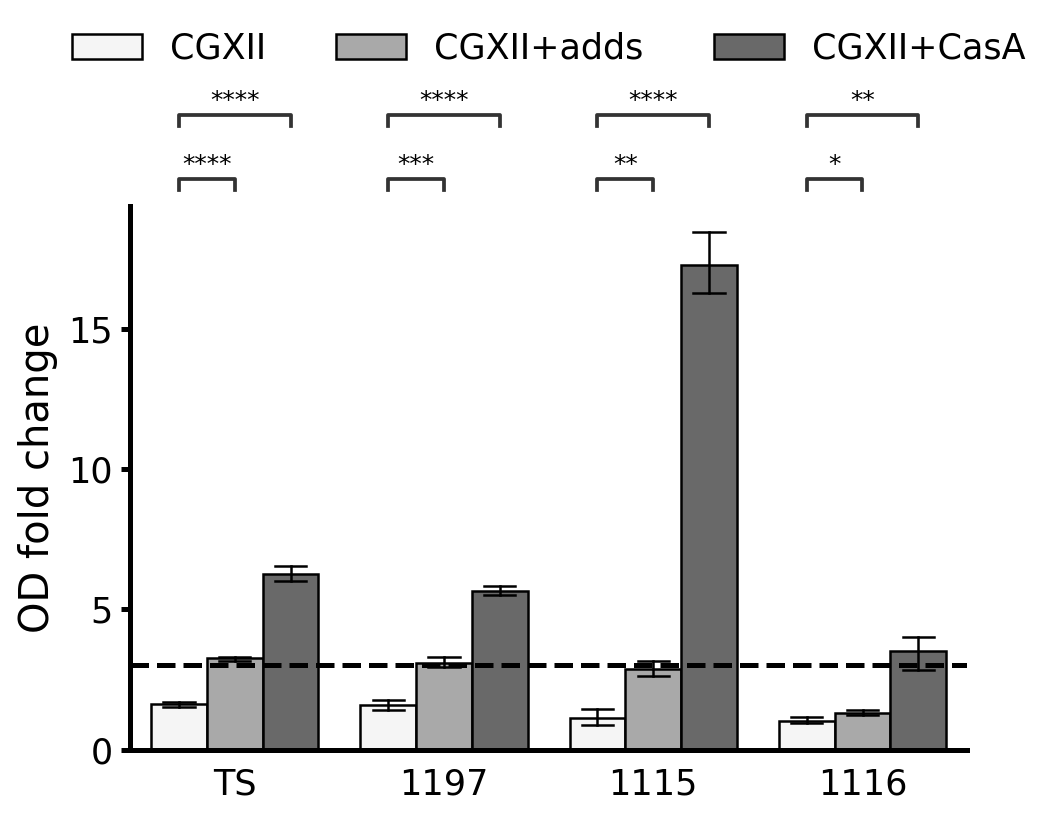

In [39]:
hue_order = ['CGXII', 'CGXII+adds', 'CGXII+CasA']
fig = create_barplot_stats_triple(data,x,y,hue,hue_order)
plt.savefig('../figures/plots_with_stats/CGXII_sig_triple.png', bbox_inches='tight', dpi=300)

In [7]:
def create_barplot_stats_four_cgx(data, x, y, hue, hue_order, pair1=None, pair2=None, fold=True):
    strains = STRAINS_LAB.values()
    
    f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True, gridspec_kw={'height_ratios': [1, 5]}, figsize=(8,6))

    ax1 = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=['white', 'lightgrey', 'darkgrey', 'dimgrey'], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values(),
                 ax=ax1)
    
    ### barplot with errorbars ###
    ax2 = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=['white', 'lightgrey', 'darkgrey', 'dimgrey'], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values(), ax=ax2)
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        pair3 = hue_order[2]
        pair4 = hue_order[3]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains] + [((strain, pair1), (strain, pair3))
                for strain in strains] + [((strain, pair1), (strain, pair4))
                for strain in strains]
    
    ### styling ###
    #ax.legend(title=None, ncol=2)
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax1.legend(loc="lower center", bbox_to_anchor=(.5, 1.1), ncol=2, title=None, frameon=False)
    #sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5), title=None, frameon=False)
    #ax1.set_yticks(np.arange(20, 35, step=5))
    ax1.set_ylim(15,35)
    ax1.tick_params(left=False)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.spines['bottom'].set_visible(False) 
    ax1.spines['left'].set_visible(False) 

    ax2.set_ylim(0, 14.5)
    ax2.tick_params(bottom=False) 
    #ax.set_ylim(0,15.5)
    ax2.set_yticks(np.arange(0, 14.5, step=3))
    
    annotator = Annotator(ax2, pairs, data=data, x=x, y=y, hue=hue, hue_order=hue_order, order=STRAINS_LAB.values())
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_test().annotate()

    f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)
    
    #ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax1.set_ylabel(None)
    ax1.set_xlabel(None)
    
    return f

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1116_CGXII vs. 1116_CGXII+Tw: t-test independent samples, P_val:1.637e-01 t=-1.703e+00
1115_CGXII vs. 1115_CGXII+Tw: t-test independent samples, P_val:3.511e-03 t=-6.167e+00
TS_CGXII vs. TS_CGXII+Tw: t-test independent samples, P_val:1.640e-05 t=-2.453e+01
1197_CGXII vs. 1197_CGXII+Tw: t-test independent samples, P_val:4.813e-01 t=-7.756e-01
1116_CGXII vs. 1116_CGXII+Tw+adds: t-test independent samples, P_val:2.475e-02 t=-3.506e+00
TS_CGXII vs. TS_CGXII+Tw+adds: t-test independent samples, P_val:1.640e-05 t=-2.453e+01
1197_CGXII vs. 1197_CGXII+Tw+adds: t-test independent samples, P_val:7.068e-04 t=-9.424e+00
1115_CGXII vs. 1115_CGXII+Tw+adds: t-test independent samples, P_val:1.662e-03 t=-7.534e+00
1116_CGXII vs. 1116_CGXII+Tw+adds+CasA: t-test independent samples, P_val:3.841e-05 t=-1.980e+01
1115_CGXII vs.

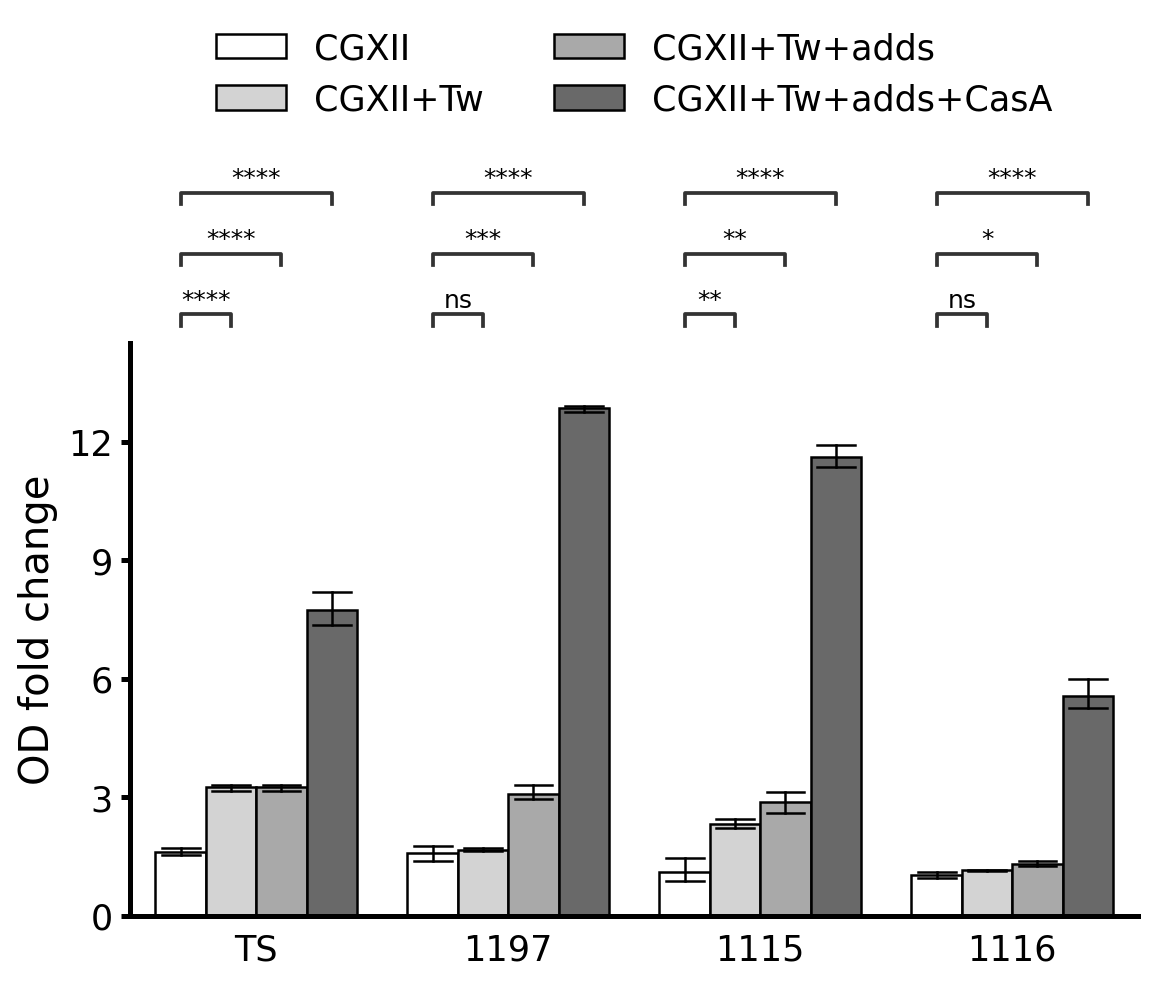

In [12]:
data.replace({'CGXII+Tween': 'CGXII+Tw', 'CGXII+adds': 'CGXII+Tw+adds', 'CGXII+adds+CasA': 'CGXII+Tw+adds+CasA'}, inplace=True)
hue_order = ['CGXII', 'CGXII+Tw', 'CGXII+Tw+adds', 'CGXII+Tw+adds+CasA']
fig = create_barplot_stats_four_cgx(data,x,y,hue,hue_order)
plt.savefig('../figures/plots_with_stats/CGXII_sig_four.png', bbox_inches='tight', dpi=300)

## 8. LB und RPMI

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:1.454e-05 t=-2.528e+01
TS_0 vs. TS_24: t-test independent samples, P_val:7.849e-06 t=-2.951e+01
1115_0 vs. 1115_24: t-test independent samples, P_val:3.781e-04 t=-1.107e+01
1116_0 vs. 1116_24: t-test independent samples, P_val:3.164e-04 t=-1.159e+01


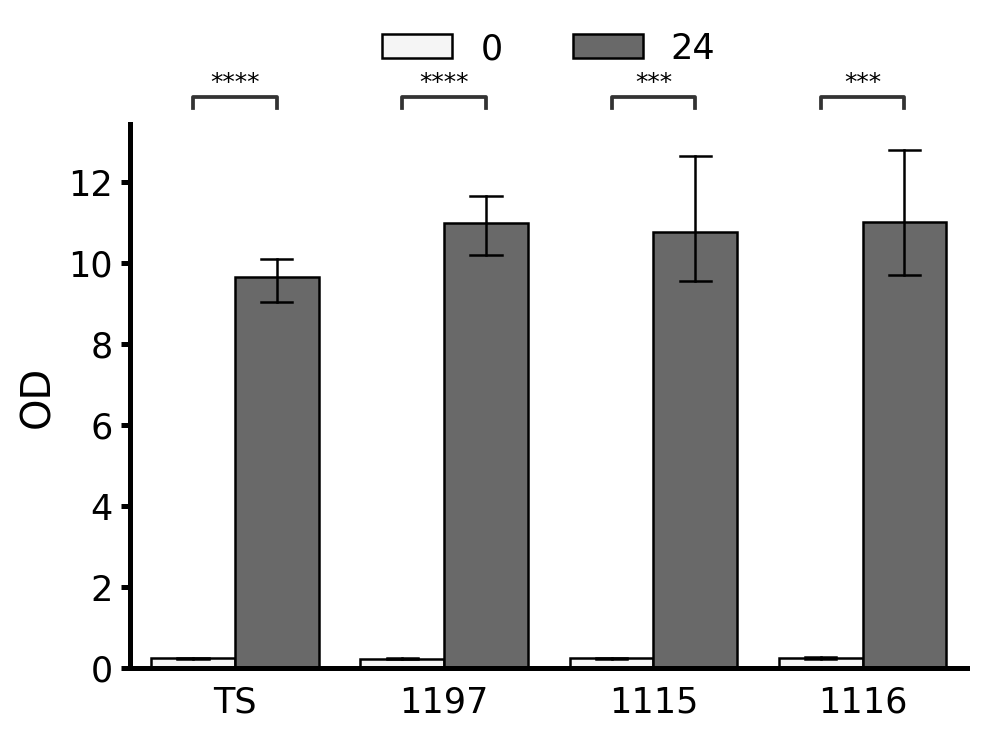

In [16]:
data = pd.read_csv('../data/agg/LB_OD.csv')
data = data[data['short'] == 'LB']
x = 'strain'
y = 'OD'
hue = 'time'
hue_order = [0, 24]
create_barplot_stats(data, x, y, hue, hue_order, fold=False)
plt.savefig('../figures/plots_with_stats/LB_sig_0to24.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:5.113e-06 t=-3.286e+01
TS_0 vs. TS_24: t-test independent samples, P_val:1.942e-05 t=-2.350e+01
1115_0 vs. 1115_24: t-test independent samples, P_val:1.679e-05 t=-2.438e+01
1116_0 vs. 1116_24: t-test independent samples, P_val:1.610e-07 t=-7.811e+01


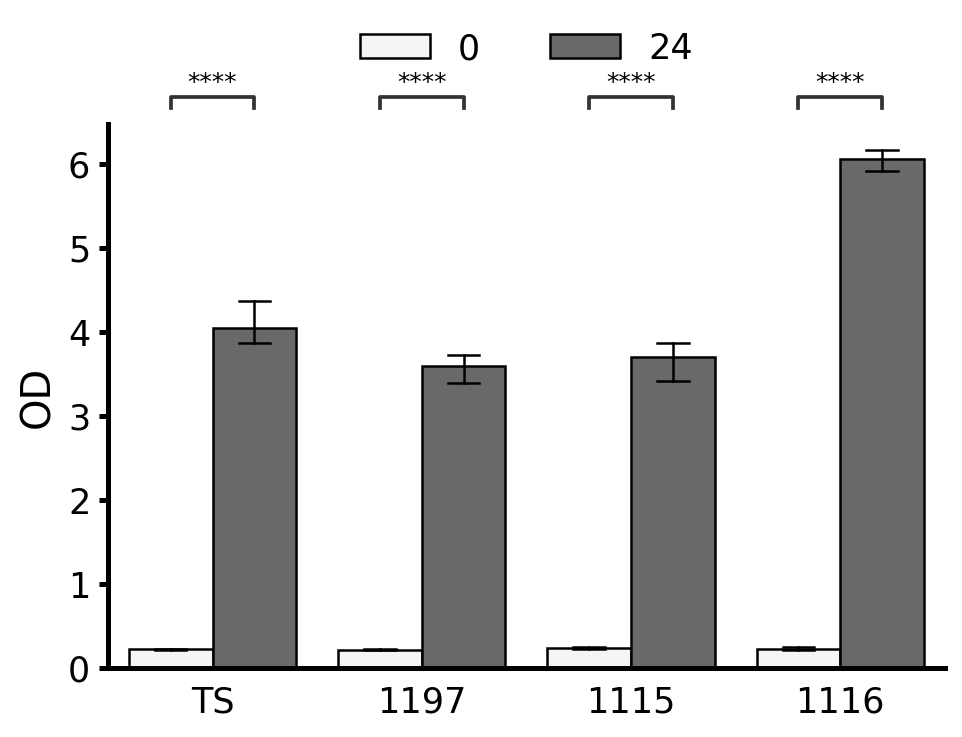

In [13]:
data = pd.read_csv('../data/agg/RPMI_OD.csv')
data = data[data['short'] == 'RPMI']
x = 'strain'
y = 'OD'
hue = 'time'
hue_order = [0, 24]
create_barplot_stats(data, x, y, hue, hue_order, fold=False)
plt.savefig('../figures/plots_with_stats/RPMI_sig_0to24.png', bbox_inches='tight', dpi=300)

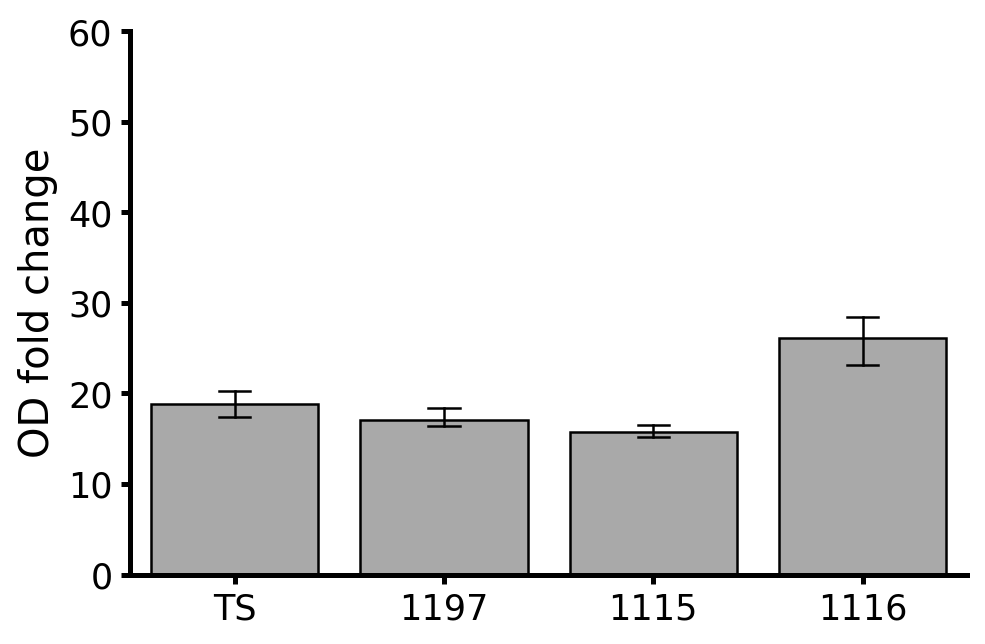

In [6]:
time = [v for k, v in pd.read_csv('../data/agg/RPMI_OD.csv').groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
ax = sns.barplot(data=change, x='strain', y='OD fold change',
                 estimator=np.mean, 
                 palette=[greys[4], greys[4]], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
ax.set_xlabel(None)
ax.set_ylim(0,60)
plt.savefig('../figures/plots_with_stats/RPMI_folds.png', bbox_inches='tight', dpi=300)

In [17]:
time = [v for k, v in data.groupby('time')]
change = time[1]
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
change.groupby('strain').mean()

,OD,time,sample,OD fold change
strain,,,,
1115,10.768000,24,2,46.195414
1116,10.994333,24,2,46.225190
1197,10.974000,24,2,51.536157
TS,9.643667,24,2,43.050650
